# Cell 1: Importing Libraries and Download Data

The libraries imported below are essential for predicting stock price movement because they provide a comprehensive toolkit for data collection, analysis, and model development. 

The yfinance library is used to fetch historical stock data directly from Yahoo Finance, while pandas and numpy handle data manipulation and numerical operations. matplotlib and seaborn are crucial for visualizing data trends and patterns. The ta library provides technical analysis indicators, which are often key features in stock prediction models. The tqdm library offers progress bars for tracking the time-consuming processes, while time helps measure the duration of operations. The itertools library aids in generating combinations for model hyperparameter tuning, and RandomForestClassifier from sklearn.ensemble is used for building the prediction model. Additionally, GridSearchCV, train_test_split, classification_report, accuracy_score, and confusion_matrix from sklearn are essential for model evaluation and optimization.


In [1]:
# Cell 1: Import Libraries and Download Data
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
import time
from tqdm import tqdm
from itertools import product
from ta import add_all_ta_features

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

# Cell 2: Indicators and Features
    
In this section, the program retrieves historical stock data of specific stock values from Yahoo Finance. Using the historical stock data, technical indicators are calculated and features are engineered to be used in developing a model that predicts stock market price movement.

## Stock Data Source
Historical stock data are retrieved using the yfinance module that accesses Yahoo’s publicly available APIs (Yahoo Finance).  By setting a specific stock symbol through the ticker, historical data are retrieved based on the set duration and timeframe (intervals). 

## Preprocessing
Retrieved data converts the index to datetime format and filters out weekends as no data are recorded in the stock market during the weekends, thus removing instances of data during the weekends. 

## Technical Indicators 
Several technical indicators are calculated in the code which identifies trends and volatility of stock prices, this includes the following technical indicators:

        Simple Moving Average (SMA)
            Window Size 20
            Window Size 50
            Window Size 100
            Window Size 200
        Exponential Moving Average (EMA)
            Window Size 20
            Window Size 50
            Window Size 100
            Window Size 200
        Relative Strength Index (RSI)
        Moving Average Convergence Divergence
            MACD Line 
            MACD Signal Line
        Average True Range (ATR)
        Bollinger Bands
            Bollinger Upper
            Bollinger Middle
            Bollinger Lower
        Stochastic Oscillator
            %K
            %D
        Average Directional Index (ADX)

## Engineered Features
Utilizing the retrieved and calculated technical indicators, new features are created (engineered). These engineered features include:

    a. Binary features that indicate whether a closing stock price is above a particular moving average (SMA100 and SMA 200).
    b. Binary feature that indicates whether SMA20 has crossed over SMA 50.
    c. Binary features indicating whether the RSI has been overbought or oversold.
    d. Binary feature indicating whether the MACD line has crossed above or below the MACD Signal Line.
    e. Binary features that indicate whether the closing stock price is above or below the upper and lower Bollinger Bands.
    f. Binary features that indicate whether the Stochastic Oscillator is overbought or oversold.
    g. Binary feature indicating if the ADX shows a strong trend.

## Target Variable Generation
Calculates the percentage change in the closing prices and assigns a value 1 (if there is a positive change in the stock price) or 0 (if there is a negative change in the stock price) to “Target”. This also removes instances of data frames that contains NaN (Not a Number) or non-numerical values, which removes row with missing data.



In [11]:
# Cell 2: Calculate Indicators and Create Features

'''Stock Data Source'''
# Specify the ticker and timeframe
ticker = 'EA'
timeframe = '1d'

# Download historical stock data from yfinance
df = yf.download(ticker, start='2010-01-01', end='2024-08-31', interval=timeframe)

'''Preprocessing'''
# Convert the index to datetime and filter out weekends
df.index = pd.to_datetime(df.index)

'''Technical Indicators'''
# Calculate technical indicators
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()
df['SMA100'] = df['Close'].rolling(window=100).mean()
df['SMA200'] = df['Close'].rolling(window=200).mean()
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA100'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA200'] = df['Close'].ewm(span=50, adjust=False).mean()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
macd = ta.trend.MACD(df['Close'])
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()
df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=14).average_true_range()
bbands = ta.volatility.BollingerBands(df['Close'], window=20)
df['BB_upper'] = bbands.bollinger_hband()
df['BB_middle'] = bbands.bollinger_mavg()
df['BB_lower'] = bbands.bollinger_lband()
df['Stoch_K'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14).stoch()
df['Stoch_D'] = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14).stoch_signal()
df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Close'], window=14).adx()

'''Engineered Features'''
# Add engineered features
df['Above_SMA100'] = (df['Close'] > df['SMA100']).astype(int)
df['Above_SMA200'] = (df['Close'] > df['SMA200']).astype(int)
df['SMA20_cross_SMA50'] = ((df['SMA20'] > df['SMA50']) & (df['SMA20'].shift(1) <= df['SMA50'].shift(1))).astype(int)
df['RSI_Overbought'] = (df['RSI'] > 70).astype(int)
df['RSI_Oversold'] = (df['RSI'] < 30).astype(int)
df['MACD_Signal_Cross'] = ((df['MACD'] > df['MACD_signal']) & (df['MACD'].shift(1) <= df['MACD_signal'].shift(1))).astype(int)
df['Price_Above_Upper_BB'] = (df['Close'] > df['BB_upper']).astype(int)
df['Price_Below_Lower_BB'] = (df['Close'] < df['BB_lower']).astype(int)
df['Stoch_Overbought'] = ((df['Stoch_K'] > 80) & (df['Stoch_D'] > 80)).astype(int)
df['Stoch_Oversold'] = ((df['Stoch_K'] < 20) & (df['Stoch_D'] < 20)).astype(int)
df['ADX_Strong_Trend'] = (df['ADX'] > 25).astype(int)

'''Target Variable Generation'''
# Generate target variable
df['Return'] = df['Close'].pct_change().shift(-1)
df['Target'] = np.where(df['Return'] > 0, 1, 0)
df = df.drop(columns=['Return'])

# Drop rows with NaN values
df = df.dropna()

# Configure pandas display settings to avoid wrapping
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)  # Set the display width to prevent line wrapping

print(df.head())
print(df.tail())


[*********************100%***********************]  1 of 1 completed


            Open  High   Low  Close  Adj Close   Volume  SMA20  SMA50  SMA100  SMA200  EMA20  EMA50  EMA100  EMA200   RSI  MACD  MACD_signal  ATR  BB_upper  BB_middle  BB_lower  Stoch_K  Stoch_D   ADX  Above_SMA100  Above_SMA200  SMA20_cross_SMA50  RSI_Overbought  RSI_Oversold  MACD_Signal_Cross  Price_Above_Upper_BB  Price_Below_Lower_BB  Stoch_Overbought  Stoch_Oversold  ADX_Strong_Trend  Target
Date                                                                                                                                                                                                                                                                                                                                                                                                            
2010-10-18 15.87 16.00 15.69  15.77      15.42  6283600  16.70  16.31   15.99   16.93  16.63  16.44   16.63   16.44 39.08  0.03         0.19 0.55     17.89      16.70     15.51     3.38    10.76 14.

# Cell 3: Exploratory Data Analysis (EDA) of Stocks Data

This section presents a comprehensive Exploratory Data Analysis (EDA) of stocks data. The goal is to uncover patterns, relationships, and insights that will inform our machine learning-based trading strategy. This analysis is important to understand the characteristics of the data we're working with and the potential factors that may influence our model's predictions.

## Dataset Overview

Our dataset contains various features related to stocks data, including price data, technical indicators, and engineered features. The analysis covers daily stock data over a period of several years.

## Scope
The EDA phase will focus on the following:

**Basic Statistics:** Analyzing the summary statistics of stock prices, technical indicators, and volume.

**Missing Values:** Checking for missing data to ensure clean and reliable inputs for model training.

**Correlation Analysis:** Investigating relationships between features and identifying potential multicollinearity.

**Target Distribution:** Evaluating the balance between upward and downward price movements (i.e., our classification target).

**Visualizations:** Creating various plots to help interpret key technical indicators such as Moving Averages (SMA, EMA), RSI, MACD, and Bollinger Bands.

## Limitations

The analysis is constrained by the available historical data. As the stock market is influenced by numerous factors (e.g., macroeconomic conditions), not all relevant features may be captured in the dataset.

While technical indicators are powerful, they are lagging indicators. They are only based on past data and may not fully capture future price dynamics. This can limit the predictive power of the model, especially in highly volatile or news-driven markets.


Basic Statistics:
         Open    High     Low   Close  Adj Close      Volume   SMA20   SMA50  SMA100  SMA200   EMA20   EMA50  EMA100  EMA200     RSI    MACD  MACD_signal     ATR  BB_upper  BB_middle  BB_lower  Stoch_K  Stoch_D     ADX  Above_SMA100  Above_SMA200  SMA20_cross_SMA50  RSI_Overbought  RSI_Oversold  MACD_Signal_Cross  Price_Above_Upper_BB  Price_Below_Lower_BB  Stoch_Overbought  Stoch_Oversold  ADX_Strong_Trend  Target
count 3491.00 3491.00 3491.00 3491.00    3491.00     3491.00 3491.00 3491.00 3491.00 3491.00 3491.00 3491.00 3491.00 3491.00 3491.00 3491.00      3491.00 3491.00   3491.00    3491.00   3491.00  3491.00  3491.00 3491.00       3491.00       3491.00            3491.00         3491.00       3491.00            3491.00               3491.00               3491.00           3491.00         3491.00           3491.00 3491.00
mean    83.31   84.27   82.32   83.32      81.87  3808817.82   82.96   82.40   81.53   79.84   82.96   82.42   82.96   82.42   53.02    0.26    

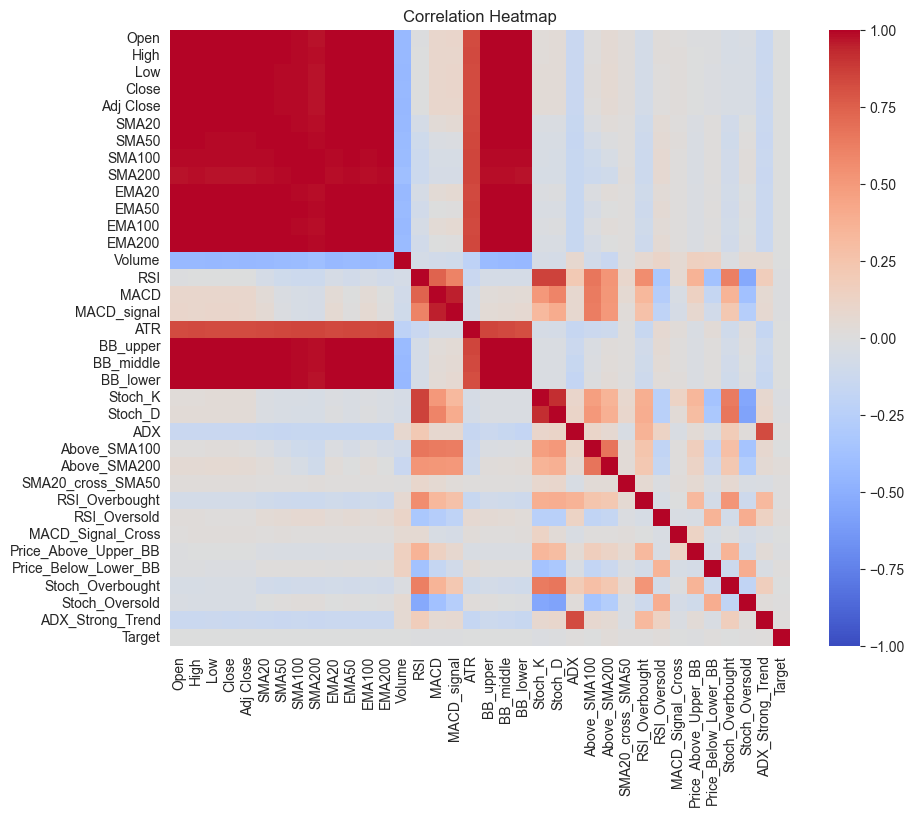

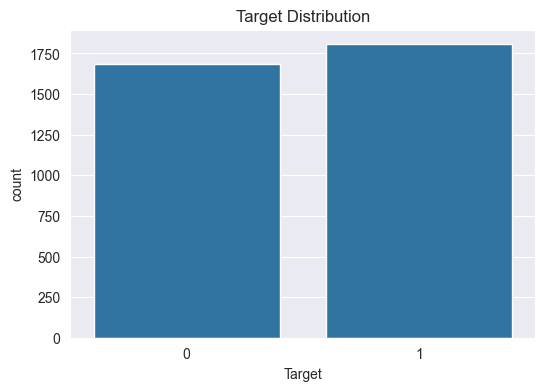

<Figure size 1500x700 with 0 Axes>

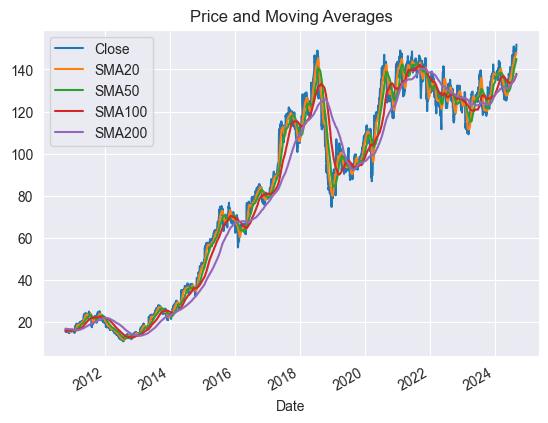

<Figure size 1500x700 with 0 Axes>

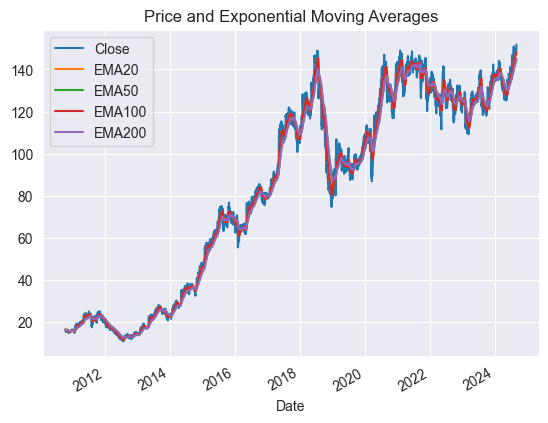

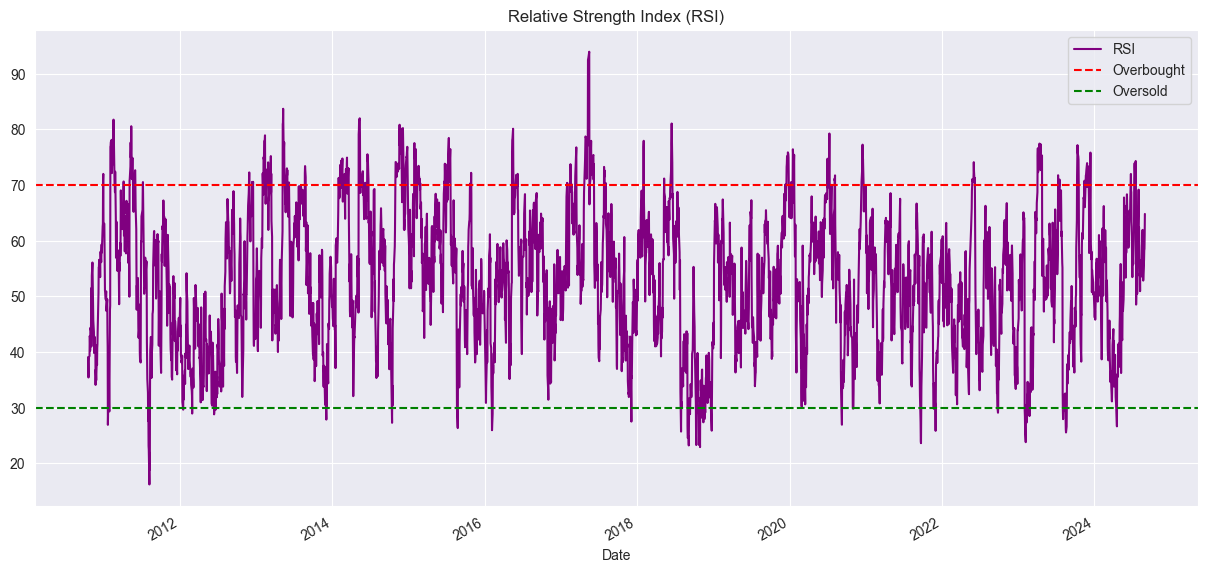

<Figure size 1500x700 with 0 Axes>

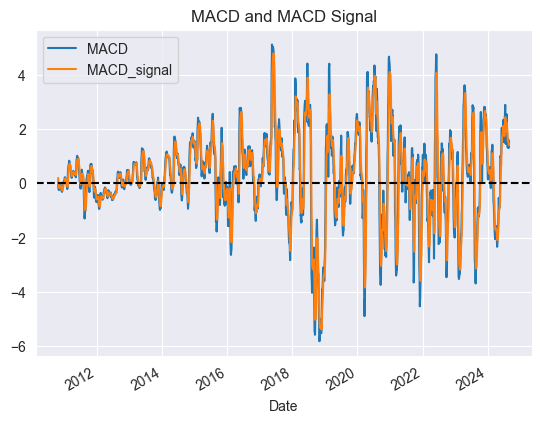

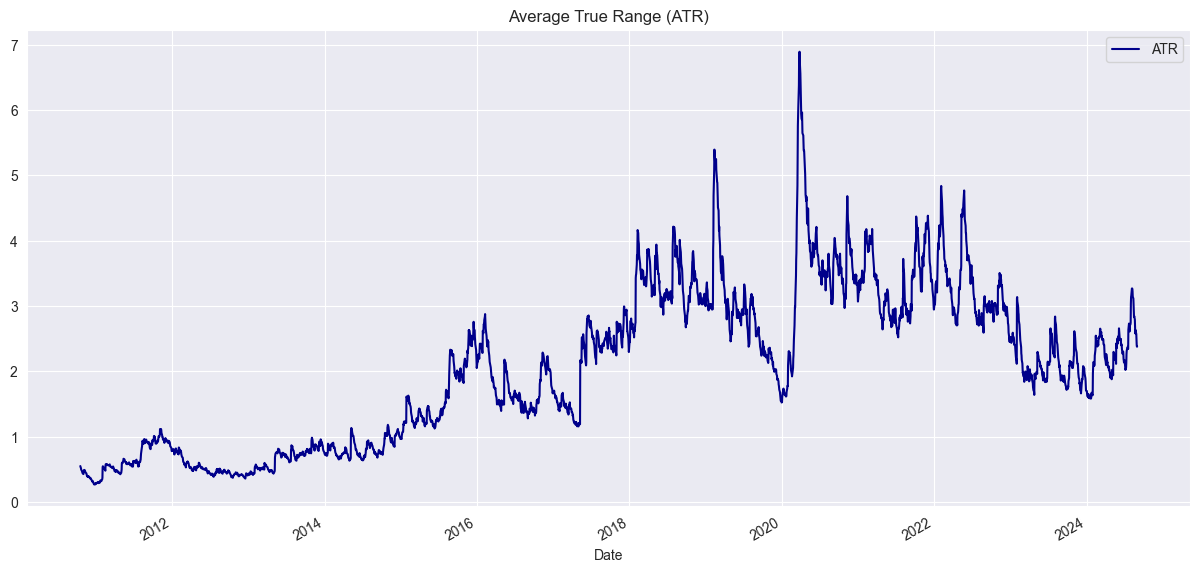

<Figure size 1500x700 with 0 Axes>

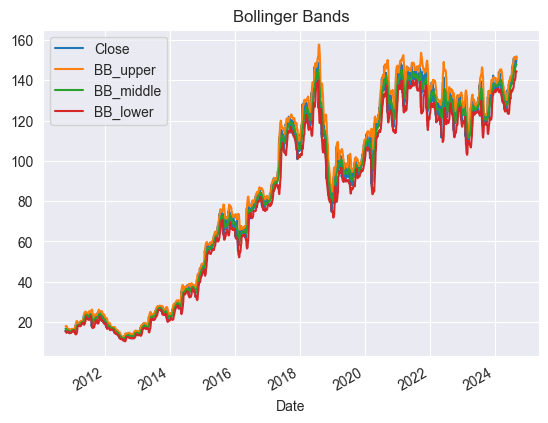

<Figure size 1500x700 with 0 Axes>

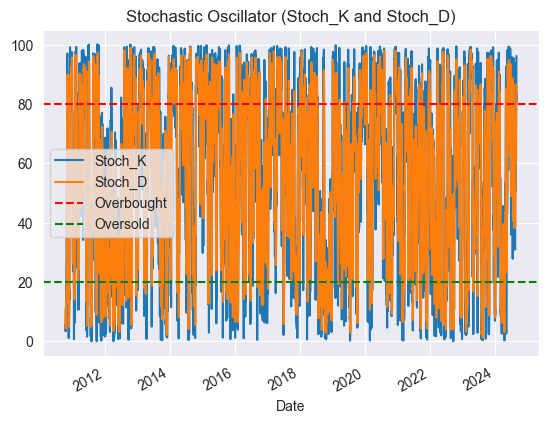

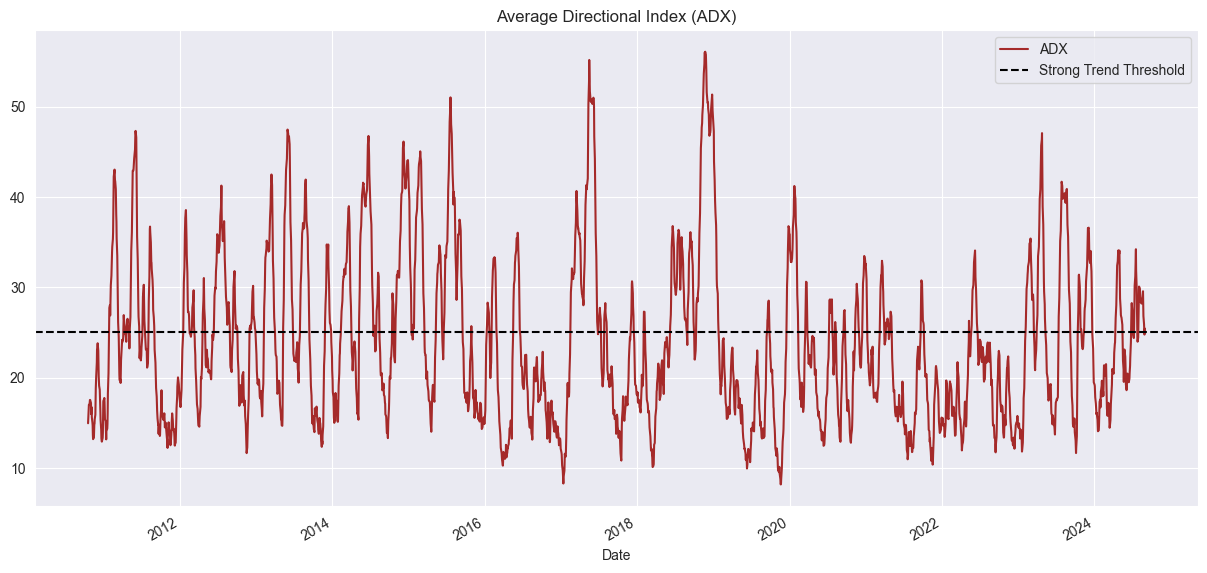

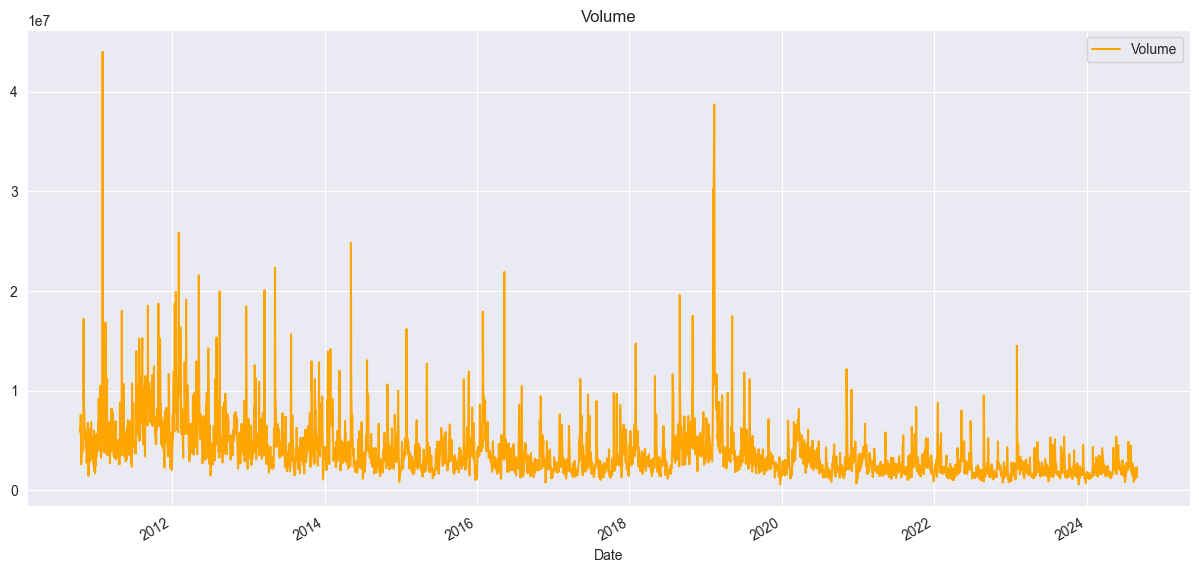

In [12]:
# Cell 3: Exploratory Data Analysis (EDA)

# Set display options
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', 1000)         # Prevent wrapping to the next line
pd.set_option('display.float_format', '{:.2f}'.format)  # Round values to 3 decimal places

# Basic Statistics
print("Basic Statistics:")
print(df.describe())

# Missing Values
print("\nMissing Values:")
print(df.isnull().sum())

# Define features
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'SMA20', 'SMA50', 'SMA100', 'SMA200', 'EMA20', 'EMA50', 
            'EMA100', 'EMA200', 'Volume', 'RSI', 'MACD', 'MACD_signal', 'ATR', 'BB_upper', 'BB_middle', 'BB_lower', 'Stoch_K', 
            'Stoch_D', 'ADX', 'Above_SMA100', 'Above_SMA200', 'SMA20_cross_SMA50', 'RSI_Overbought', 'RSI_Oversold', 
            'MACD_Signal_Cross', 'Price_Above_Upper_BB', 'Price_Below_Lower_BB', 'Stoch_Overbought', 'Stoch_Oversold', 
            'ADX_Strong_Trend']

# Correlation Matrix
correlation_matrix = df[features + ['Target']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Target Distribution
target_distribution = df['Target'].value_counts(normalize=True)
print("\nTarget Distribution:")
print(target_distribution)

# Plot Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

# Plot Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Target', data=df)
plt.title('Target Distribution')
plt.show()

# Plot Price and Moving Averages
plt.figure(figsize=(15, 7))
df[['Close', 'SMA20', 'SMA50', 'SMA100', 'SMA200']].plot()
plt.title('Price and Moving Averages')
plt.legend()
plt.show()

# Plot Exponential Moving Averages (EMA)
plt.figure(figsize=(15, 7))
df[['Close', 'EMA20', 'EMA50', 'EMA100', 'EMA200']].plot()
plt.title('Price and Exponential Moving Averages')
plt.legend()
plt.show()

# Plot Relative Strength Index (RSI)
plt.figure(figsize=(15, 7))
df['RSI'].plot(label='RSI', color='purple')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('Relative Strength Index (RSI)')
plt.legend()
plt.show()

# Plot MACD and MACD Signal
plt.figure(figsize=(15, 7))
df[['MACD', 'MACD_signal']].plot()
plt.axhline(0, linestyle='--', color='black')
plt.title('MACD and MACD Signal')
plt.legend()
plt.show()

# Plot Average True Range (ATR)
plt.figure(figsize=(15, 7))
df['ATR'].plot(label='ATR', color='darkblue')
plt.title('Average True Range (ATR)')
plt.legend()
plt.show()

# Plot Bollinger Bands
plt.figure(figsize=(15, 7))
df[['Close', 'BB_upper', 'BB_middle', 'BB_lower']].plot()
plt.title('Bollinger Bands')
plt.legend()
plt.show()

# Plot Stochastic Oscillator (Stoch_K and Stoch_D)
plt.figure(figsize=(15, 7))
df[['Stoch_K', 'Stoch_D']].plot()
plt.axhline(80, linestyle='--', color='red', label='Overbought')
plt.axhline(20, linestyle='--', color='green', label='Oversold')
plt.title('Stochastic Oscillator (Stoch_K and Stoch_D)')
plt.legend()
plt.show()

# Plot ADX (Average Directional Index)
plt.figure(figsize=(15, 7))
df['ADX'].plot(label='ADX', color='brown')
plt.axhline(25, linestyle='--', color='black', label='Strong Trend Threshold')
plt.title('Average Directional Index (ADX)')
plt.legend()
plt.show()


# Plot Volume
plt.figure(figsize=(15, 7))
df['Volume'].plot(label='Volume', color='orange')
plt.title('Volume')
plt.legend()
plt.show()


## Basic Statistics

Let's start by examining the basic statistics of our numerical features:

1. **Price Data**: 
   - The stock price (Open, High, Low, Close, Adj Close) ranges from about $10.71 to $153.51, with a mean around $83.31.
   - This wide range suggests significant growth in AMZN stock over the period covered.

2. **Volume**: 
   - The average daily trading volume is about 3.8 million shares.
   - Ranges from about 583,900 to 43.99 million shares.
   - High variability in volume indicates periods of increased trading activity.

3. **Technical Indicators**:
   - Moving Averages (SMA, EMA) closely follow the price data.
   - RSI averages around 53, indicating a slight bullish tendency overall.
   - MACD and MACD_signal average around 0.26, suggesting overall upward momentum.

4. **Target Variable**:
   - Binary classification (0 or 1).
   - Mean of 0.52 indicates a slight bias towards positive outcomes (price increases).

## Missing Values

There are no missing values in our dataset, which is excellent for our analysis and modeling efforts. We won't need to implement any imputation strategies.

## Correlation Analysis

The correlation matrix provides insights into relationships between variables:

1. **Price-related Features**:
   - High correlation (near 1.0) among Open, High, Low, Close, Adj Close prices, moving averages (SMA, EMA), and ATR.
   - This strong correlation is expected but may lead to multicollinearity in our model.
   - We may need to select only one or a few of these highly correlated features to avoid redundancy and potential overfitting.

2. **Volume Correlations**:
   - Weak negative correlation with price-related features (correlation ≈ -0.14).
   - This suggests that trading volume might provide some independent information not captured by price movements.
   - Volume could be a valuable feature to include in our model.

3. **Technical Indicator Correlations**:
   - RSI shows moderate positive correlation (0.62) with MACD, indicating agreement in momentum signals.
   - Stochastic oscillator (Stoch_K, Stoch_D) highly correlated with RSI (0.84, 0.83), suggesting redundancy in overbought/oversold signals.
   - ADX shows weak correlations with most features, indicating its independence as a trend strength measure.
   - We might consider using only one or two of these indicators to avoid redundancy.

4. **Target Variable Correlations**:
   - Very weak correlations with all features (near 0).
   - This suggests that predicting the target (likely the price direction) is not easy based on any single feature.
   - We'll likely need to use a combination of features and possibly engineer new features to improve our predictive power.
   
## Distribution of Target Variable

- The target variable is slightly imbalanced:
  - 52% of the samples are labeled as 1 (price increase).
  - 48% of the samples are labeled as 0 (price decrease or no change).
- This slight imbalance shouldn't significantly impact our model training, but we should keep it in mind when evaluating performance.

## Key Insights for Model Training

1. **Feature Selection**: 
   - High correlation among price data and moving averages suggests we can select a subset of these features to reduce multicollinearity.
   - Consider using one or two from each group of highly correlated features (one price indicator, one moving average, etc.).
   - Assess the importance of binary indicators like Price_Above_Upper_BB or SMA20_cross_SMA50. If they don't contribute significantly to model performance, consider excluding them.

2. **Feature Engineering**:
   - The weak correlations with the target variable suggest we may need to create more complex features or interaction terms.
   - Consider using lagged variables or rolling statistics to capture time-dependent patterns.

3. **Model Choice**:
   - The non-linear relationships and weak individual feature correlations with the target suggest that Tree-Based Models like Random Forest and Gradient Boosting are needed. These models are generally robust to multicollinearity and can handle a large number of features, including redundant ones. They also provide feature importance scores.

4. **Handling Class Imbalance**:
   - The slight class imbalance may not require specific techniques, but we should use appropriate evaluation metrics (e.g., F1-score, ROC AUC) rather than just accuracy.

5. **Feature Scaling**:
   - Given the wide range of values across features, we should apply feature scaling (e.g., StandardScaler) before model training.

6. **Time Series Considerations**:
   - Although not explicit in this EDA, we're dealing with time series data. We should ensure our train-test split respects the temporal order of the data.
   - Consider using time series cross-validation techniques for model evaluation.

## Next Steps

1. Implement feature selection based on correlation analysis and domain knowledge.
2. Engineer additional features to capture complex patterns.
3. Prepare the data for modeling (scaling, splitting, etc.).
4. Train the Random Forest model with careful consideration of hyperparameters.
5. Evaluate the model using appropriate metrics and validation techniques.


# Cell 4: Feature Selection, Feature and Target Setup, and Model Implementation and Training

In this specific cell, the set of codes are implemented for the feature selection and setup of the dataset purposes. Additionally, this also contains the implementation of prediction model - specifically, Random Forest Classifier - that is implemented in this project, included are the details necessary for the model implementation (such as number of decision trees, depth, and nodes) and model training (splitting of dataset to training and testing, and model evaluation/report).

## Feature Selection

Specific features are considered, selected, and used for the training and development of the model, Random Forest Classifier. Features that will be used a
    re:
Simple Moving Average (SMA     200)
Exponential Moving Average (EMA 20)
Bollinger Bands (BB     Lower)
Moving Average Convergence     (MACD)    
Volume
Relative Strength In    dex (RSI)
Average True Ra    ting (ATR)
Stochastic Osci    llator (%K)
Average Directional Index (ADX)

## Feature and Target Setup

Pandas DataFrame (df) data structure is utilized in the code to contain the datasets for the training and development of the model. In this setup, the feature variable (X) contains 9 columns which pertains to the abovementioned features selected for the model training. On the other hand, (y) refers to the target variable.

## Data Splitting

As a crucial part of model training, the dataset must be divided into subsets. Variables X and y are divided into two sets – training and test data – where, 80% of the dataset are assign (X_train, and y_train)ed as training data for model training, while the 20% remaining are ass(X_test, and y_test) igned as test data for model testing. This follows a common data splitting methods typically used for machine learning approaches. As the project deals with a large data set, the 80/20 split is a more suitable splitting option, giving the model more data data to train with, reducing the risk of overfitting, leading to better generalizations. In addition, some parameters are added, including the avoidance of shuffling before data splitting and making the data unstratified, improving the splitting of the dataset.


## Model Selection and Training

The model/algorithm that will be used in this project is the Random Forest Classifier. This model is defined as an algorithm that combines multiple decision trees, which is used for classification and regression instances. The number of decision trees are set to 100, where prediction results are then combined. Moreover, the depth of each tree can expand as deep as necessary. Samples that are, required in leaf nodes and split in internal nodes are also set at minimum of 4, and 3, respectively. To address overfitting, bootstrapping s enabled, which allows decision trees in the random forest to be trained on random subset
 of the training data. 
In training the Random Forest Classifier, model.fit() method is used whereas it takes the 80% of the feature variable (X_train) and 80% of the target variable (y_train) training data as arguments.

## Prediction and Testing

After training the model, its prediction efficiency is then tested. By taking the remaining 20% of the feature variable (X_test) as test data, the Random Forest Classifier predicts and output y_pred. resulting predictions are then compared to the other 20% of the target variable (y_test) to evaluate the performance of model. Performances evaluation includes metrics, precision, recall, f1-score and support, it returns the accuracy, macro average, and weighted averages. These results will be on the console after the testing process.
and support.

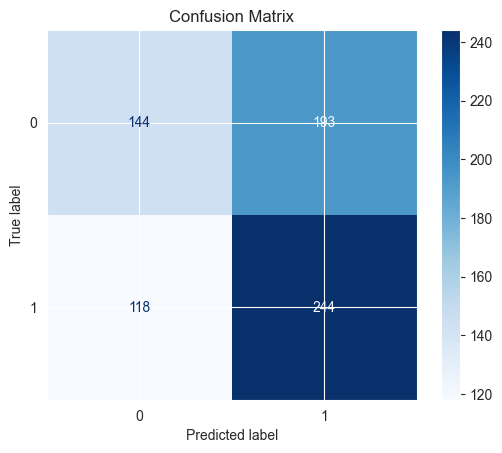

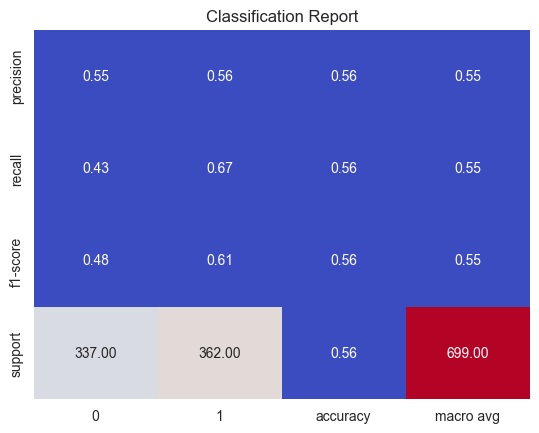

In [13]:
# Cell 4: Feature and Target Setup, Model Training

# Feature Selection
# Comment out this line if you want to use all the features for training, instead of these selected features
features = ['SMA200', 'EMA20', 'BB_lower', 'Volume', 'RSI', 'MACD', 'ATR', 'Stoch_K', 'ADX']

# Feature and Target Setup
X = df[features]
y = df['Target']

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, stratify=None)

# Model Selection and Training
model = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=20, min_samples_leaf=1, min_samples_split=10, bootstrap=False)
model.fit(X_train, y_train)

# Prediction and Testing
y_pred = model.predict(X_test)

# Classification Report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap='Blues')

# Plotting the confusion matrix
plt.title('Confusion Matrix')
plt.show()

# Displaying the classification report in a table
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap='coolwarm', fmt='.2f', cbar=False)
plt.title('Classification Report')
plt.show()

# Cell 5: Machine Learning-Based Stock Trading Strategy Backtester

## Introduction

This section provides a comprehensive overview of the backtester. Our backtester is designed to simulate real-world trading scenarios, allowing us to assess the performance of our strategy without risking actual capital. This documentation will walk you through the various components of the backtester, explain how it works, and discuss the insights we can get from its results.

## Scope and Limitations

### Scope

- Historical stock data for Electronic Arts (EA) obtained from Yahoo Finance.
- The backtester can be applied to various timeframes (e.g., daily, weekly, monthly).
- Utilizes a Random Forest Classifier to predict price movements and generate trading signals.
- Includes total profit, win rate, maximum drawdown, and Sharpe ratio.
- Provides detailed charts of overall performance and individual trades.

### Limitations

- The backtester is still far from the a real-world implementation of trading and still lack a lot of features. 
- The current implementation is tailored for EA stock. Applying it to other stocks may require adjustments to get a good result.
- The strategy's performance is based on historical data and may not guarantee future results.
- The backtester does not account for trading fees or slippage, which could impact real-world performance.
- The backtester does not include leverage trading and shorting of the market. 
- The backtester assumes all trades are executed at the closing price, which may not be realistic in practice.

## How the Strategy Works

The Random Forest Classifier predicts the probability of a price increase, interpreted as a confidence level for trading signals.

**Entry and Exit Criteria**

- **Buy Signal:** Generated when confidence exceeds 0.6 (60%).

- **Sell Signal:** Generated when confidence falls to 0.4 (40%) or below.

- **Position Sizing:** Each trade allocates 20% of the portfolio value.

- **Trade Execution:** Simulated at the closing price of the trading period.

**Performance Evaluation**

- Metrics include total profit, win rate, maximum drawdown, and Sharpe ratio.

- Detailed logs record trade data, portfolio valuation, and comparisons to a buy-and-hold strategy.

## Key Features of the Backtester

1. **Timeframe Handling**: 
   - Supports different trading timeframes (daily, weekly, monthly).
   - Filters out non-trading days for daily and longer timeframes.

2. **Trade Logging**:
   - Records detailed information for each trade, including entry/exit dates, prices, profit/loss, and confidence levels.

3. **Portfolio Valuation**:
   - Tracks portfolio value over time, allowing for comparison with a buy-and-hold strategy.

4. **Risk Management**:
   - Implements a fixed percentage capital allocation per trade to manage risk.
   - Calculates and reports maximum drawdown to assess downside risk.

5. **Performance Metrics**:
   - Computes key performance indicators such as total profit, win rate, and Sharpe ratio.

6. **Visualization Tools**:
   - Generates an overall chart showing stock price movement with buy/sell signals.
   - Creates individual trade charts for detailed analysis of each transaction.
   - Compares strategy performance against a buy-and-hold approach.

7. **Detailed Reporting**:
   - Provides a summary of portfolio performance and individual trade details.



////////////////////CONFIDENCE LEVEL PER CANDLESTICK PREDICTION////////////////////


Backtesting Progress:   0%|          | 0/699 [00:00<?, ?it/s]

Row 2792 - Confidence Level: 0.3817
Row 2793 - Confidence Level: 0.4929
Row 2794 - Confidence Level: 0.5571
Row 2795 - Confidence Level: 0.5666
Row 2796 - Confidence Level: 0.6582
Row 2797 - Confidence Level: 0.7756
Row 2798 - Confidence Level: 0.8171
Row 2799 - Confidence Level: 0.5241
Row 2800 - Confidence Level: 0.5524
Row 2801 - Confidence Level: 0.4998
Row 2802 - Confidence Level: 0.3814
Row 2803 - Confidence Level: 0.4528
Row 2804 - Confidence Level: 0.5968
Row 2805 - Confidence Level: 0.7210
Row 2806 - Confidence Level: 0.7723
Row 2807 - Confidence Level: 0.6802
Row 2808 - Confidence Level: 0.6413
Row 2809 - Confidence Level: 0.7125
Row 2810 - Confidence Level: 0.6568
Row 2811 - Confidence Level: 0.6682
Row 2812 - Confidence Level: 0.5416
Row 2813 - Confidence Level: 0.5386
Row 2814 - Confidence Level: 0.4675
Row 2815 - Confidence Level: 0.4876
Row 2816 - Confidence Level: 0.3068
Row 2817 - Confidence Level: 0.3172
Row 2818 - Confidence Level: 0.4788
Row 2819 - Confidence Level:

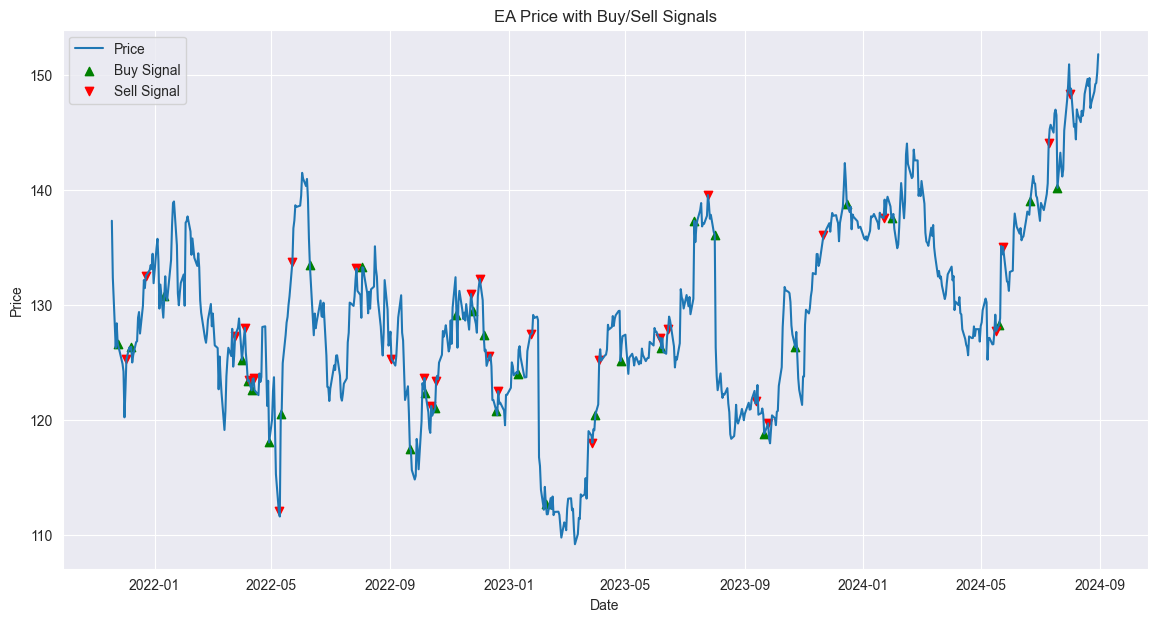

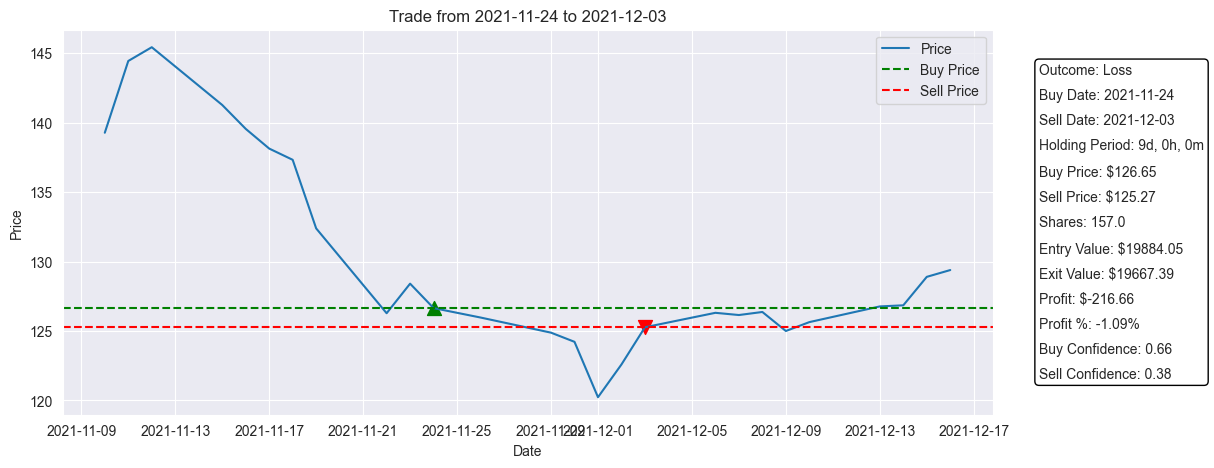

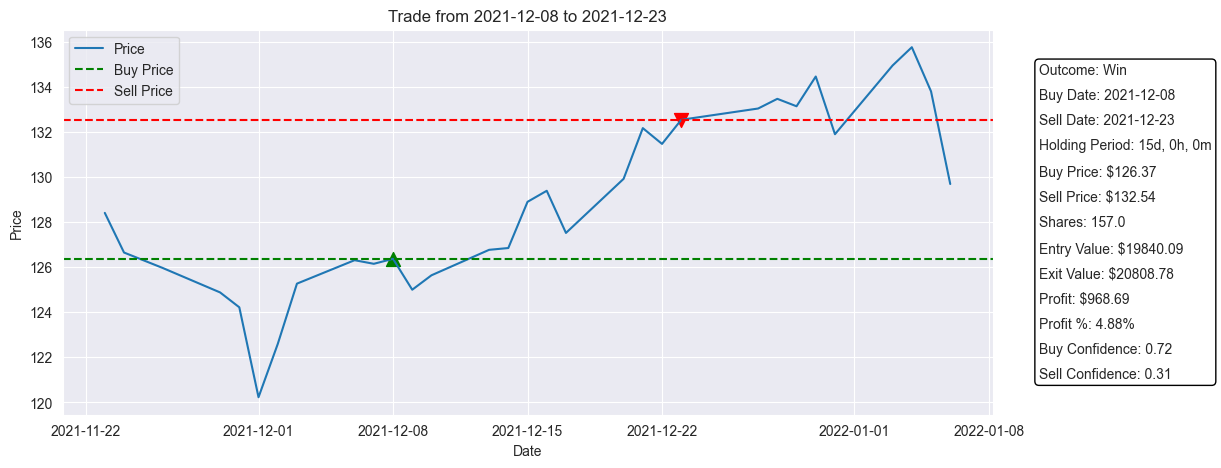

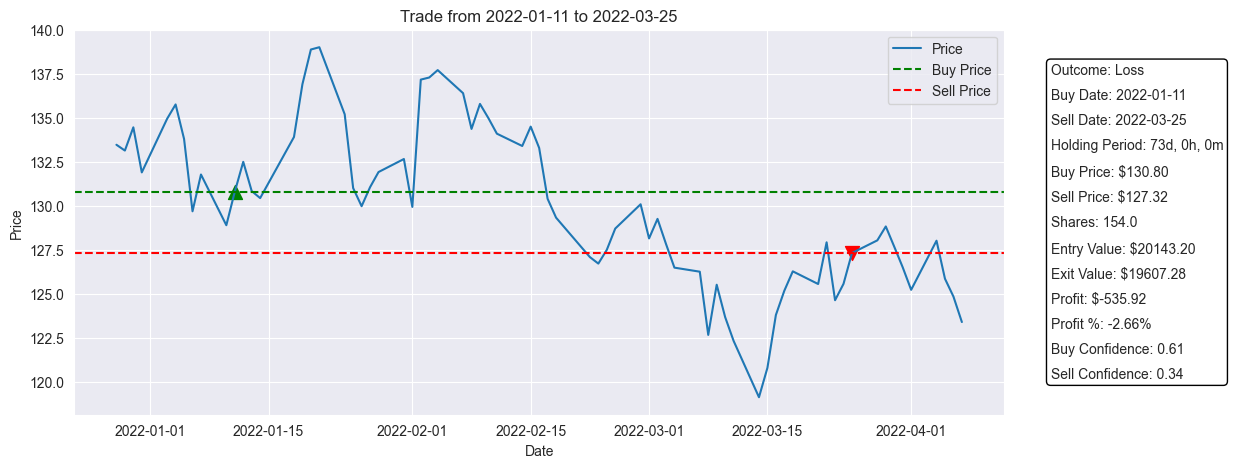

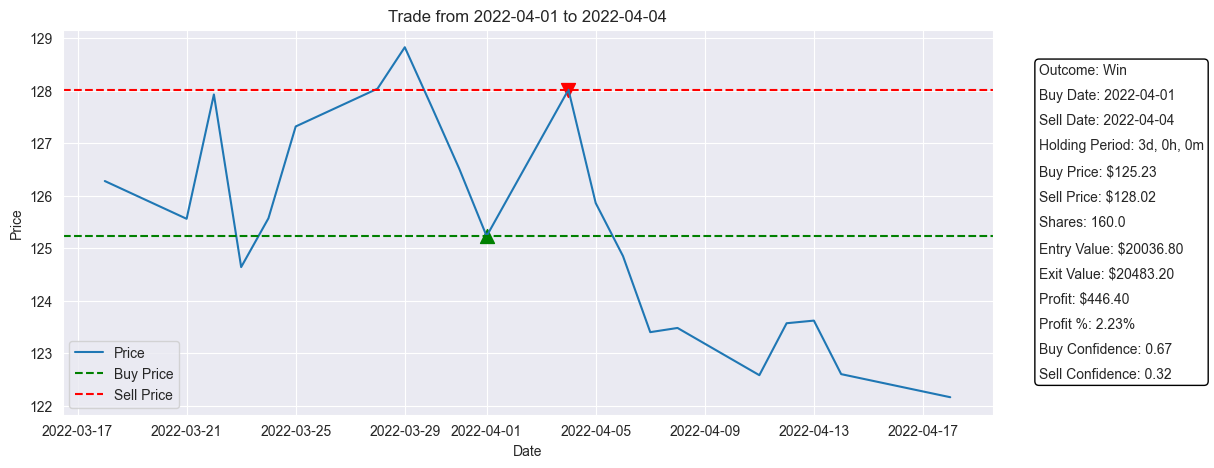

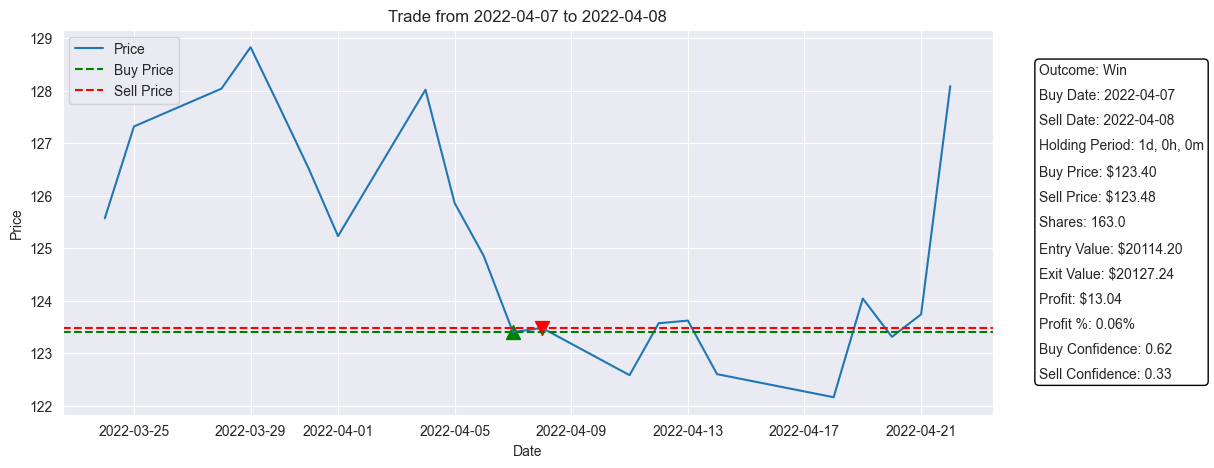

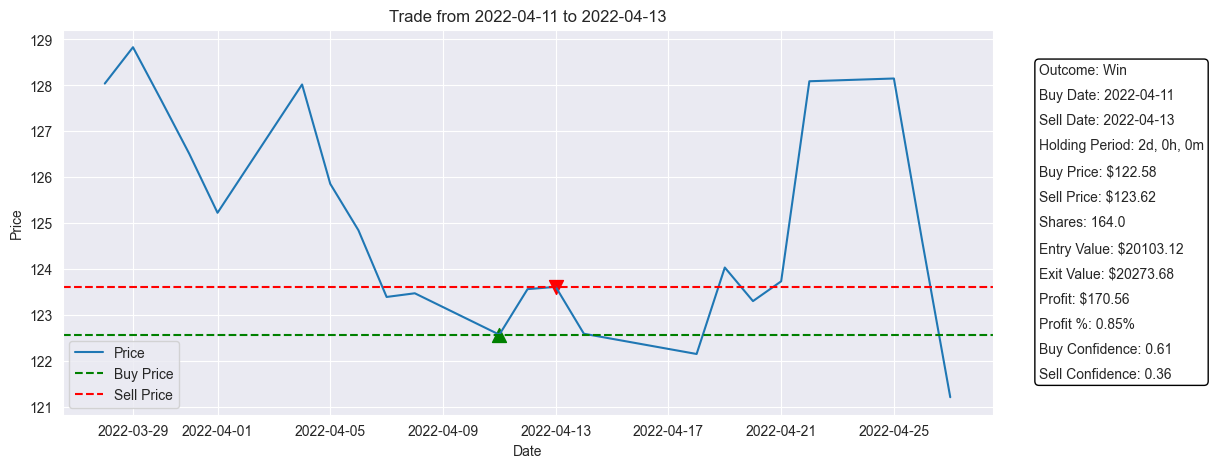

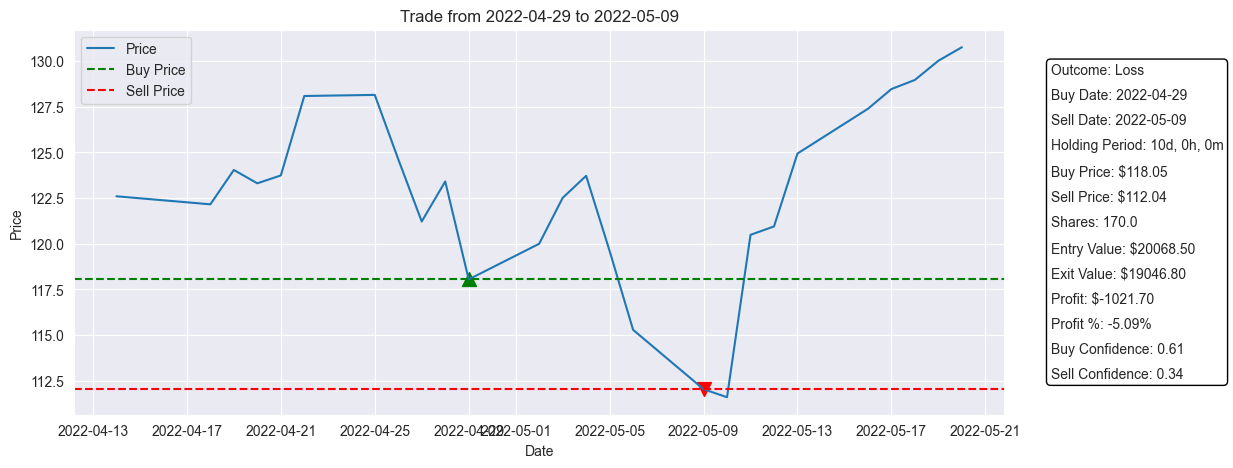

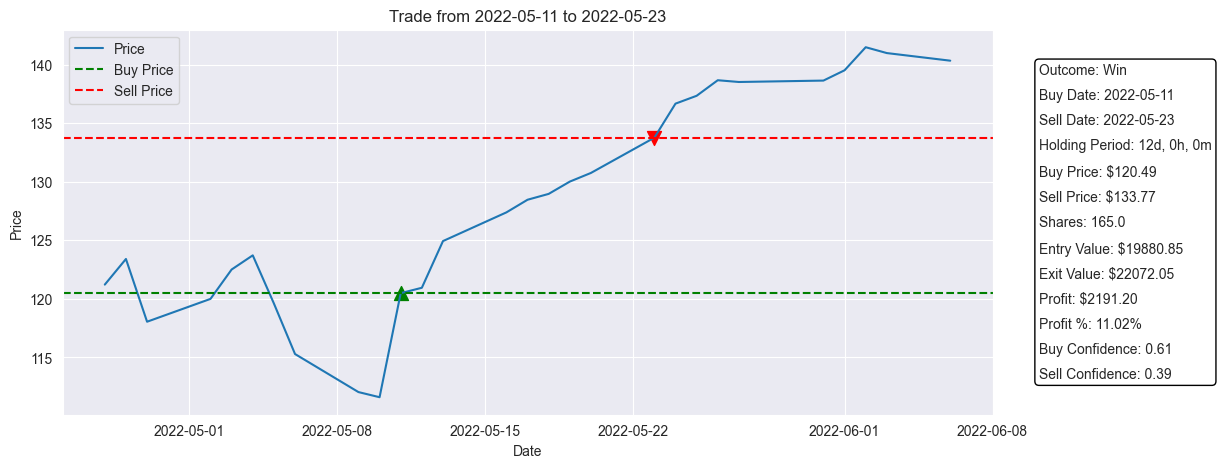

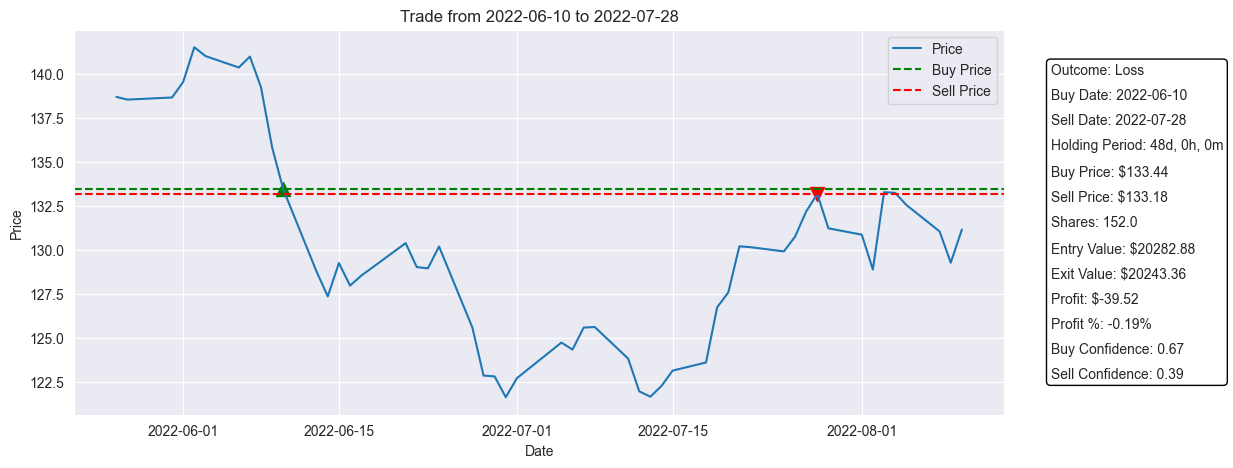

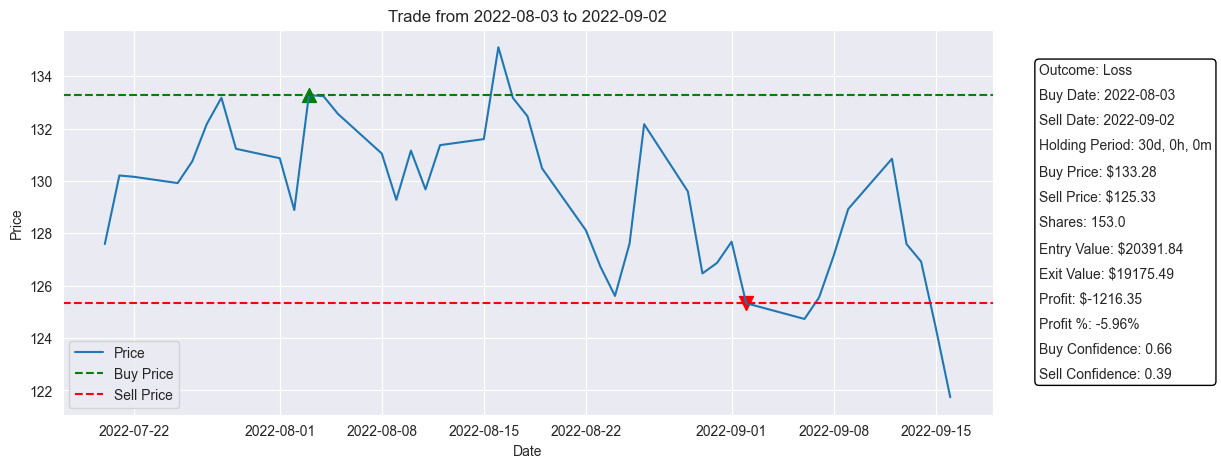

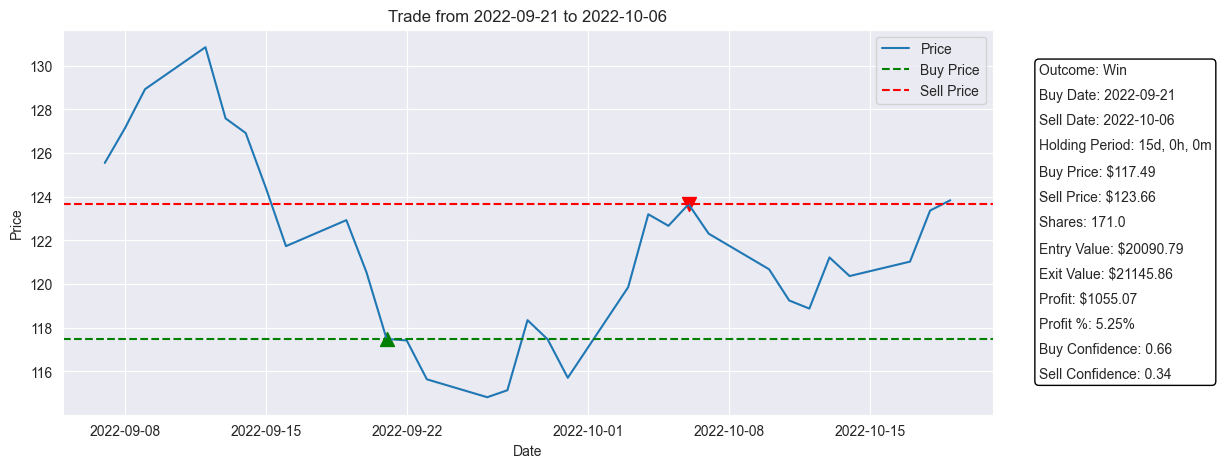

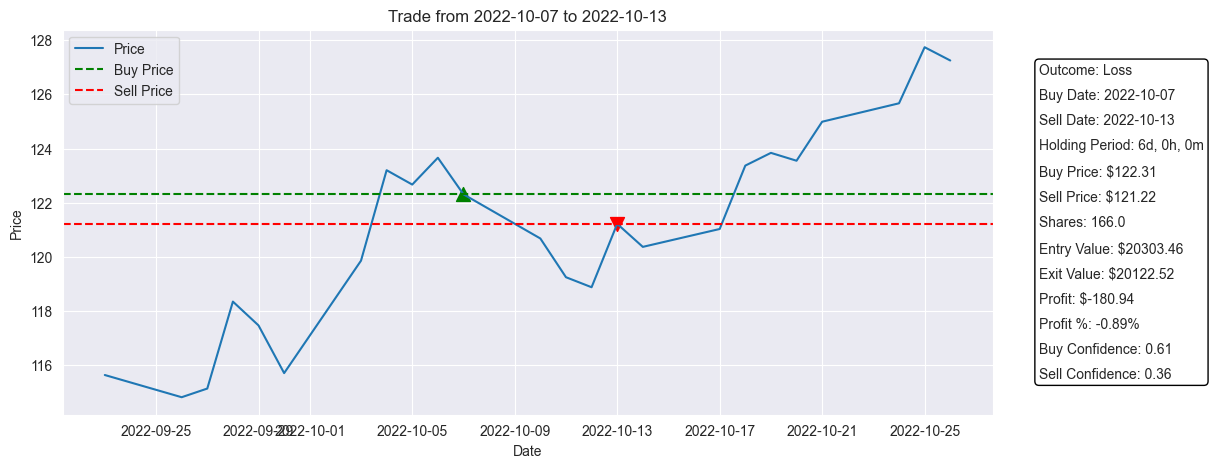

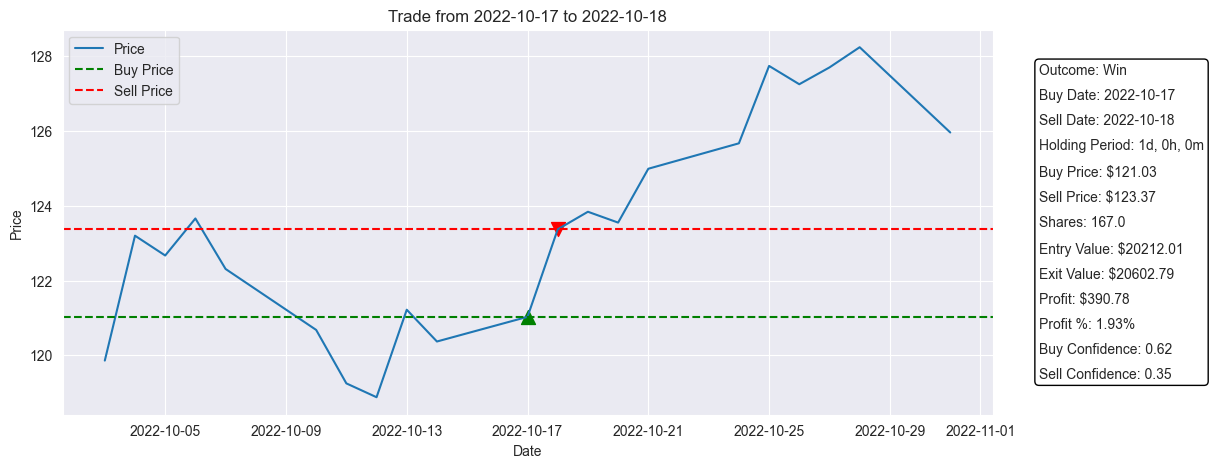

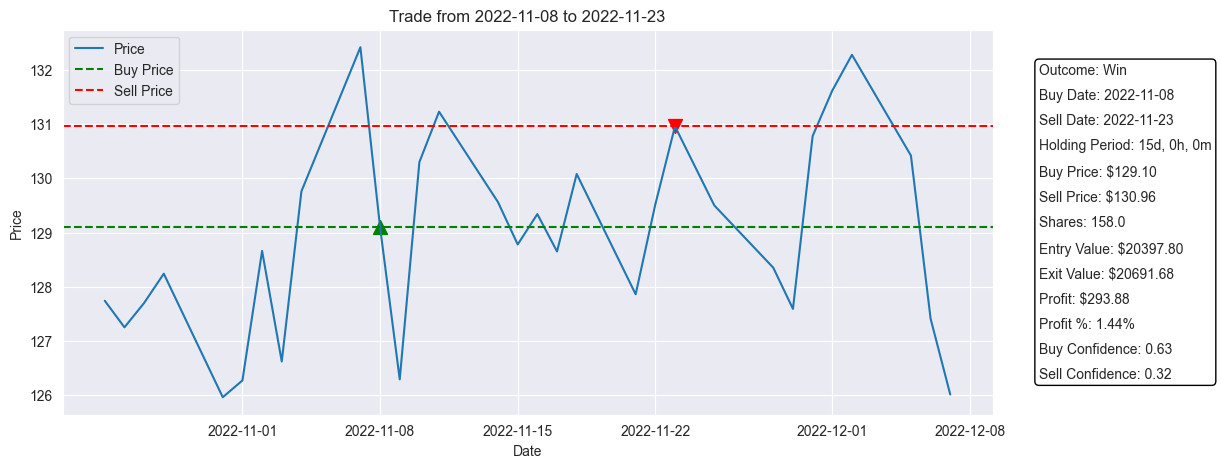

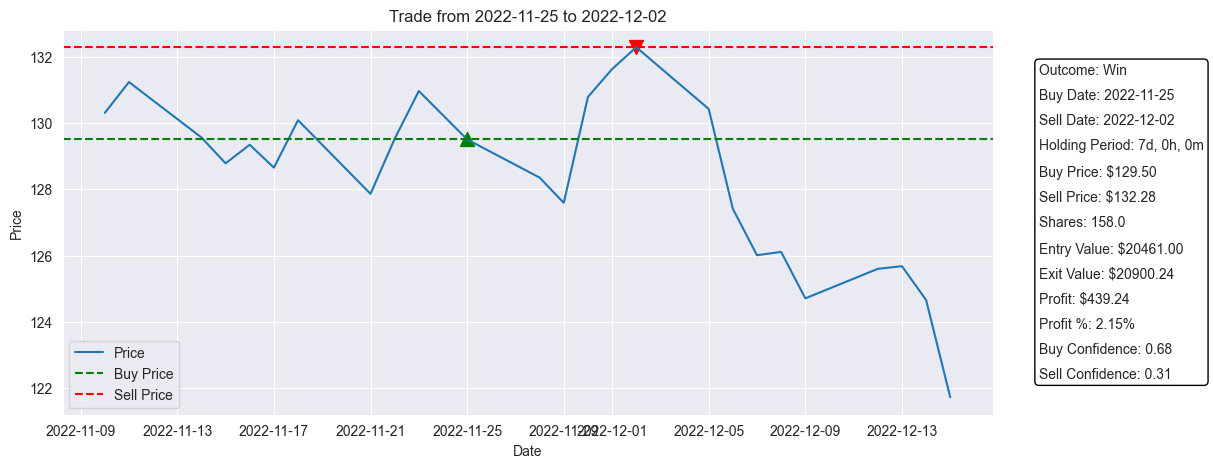

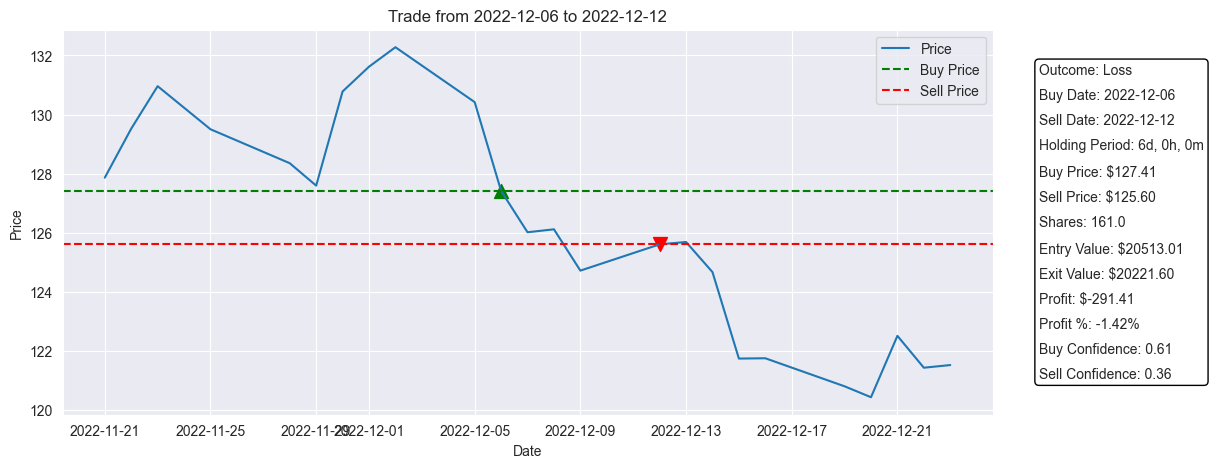

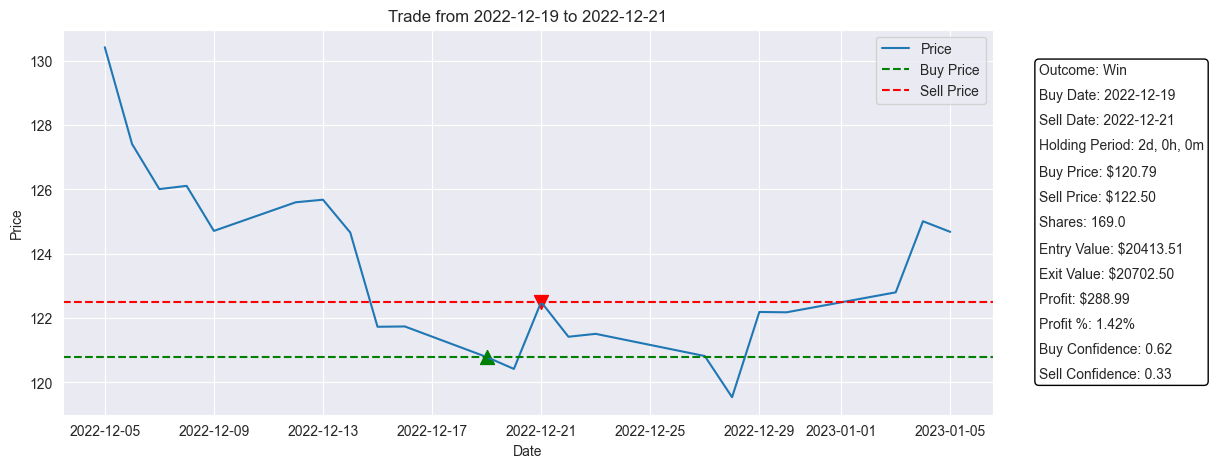

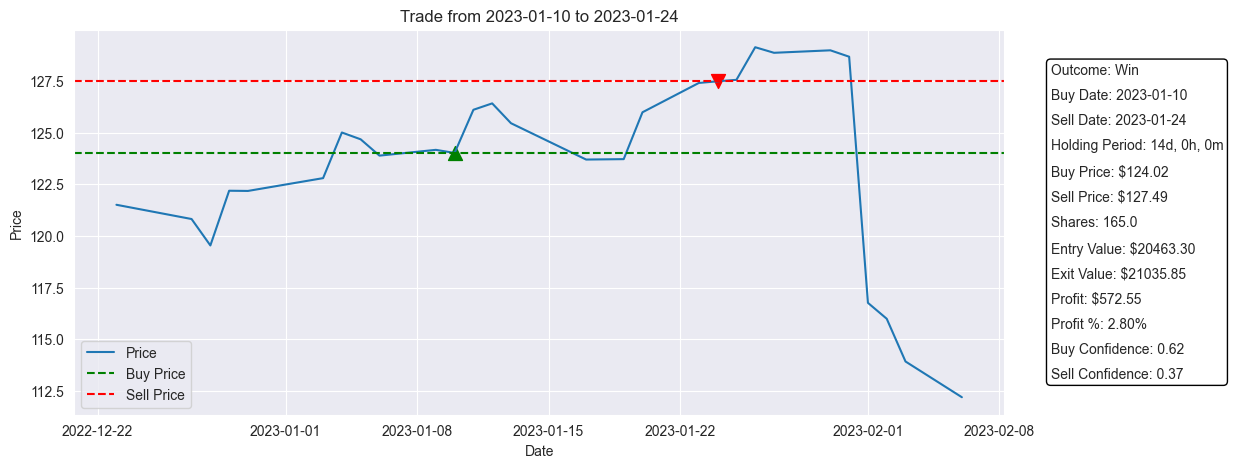

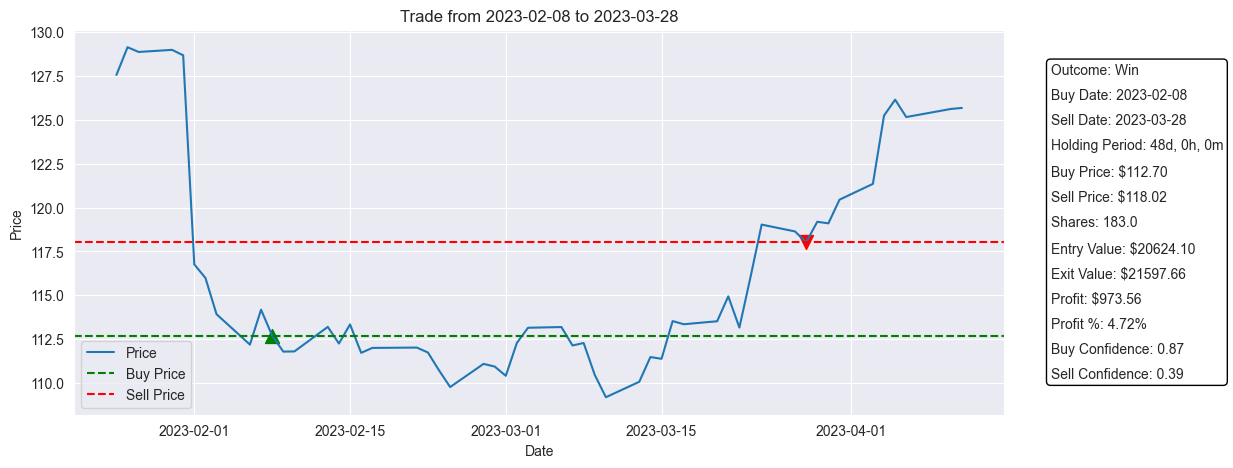

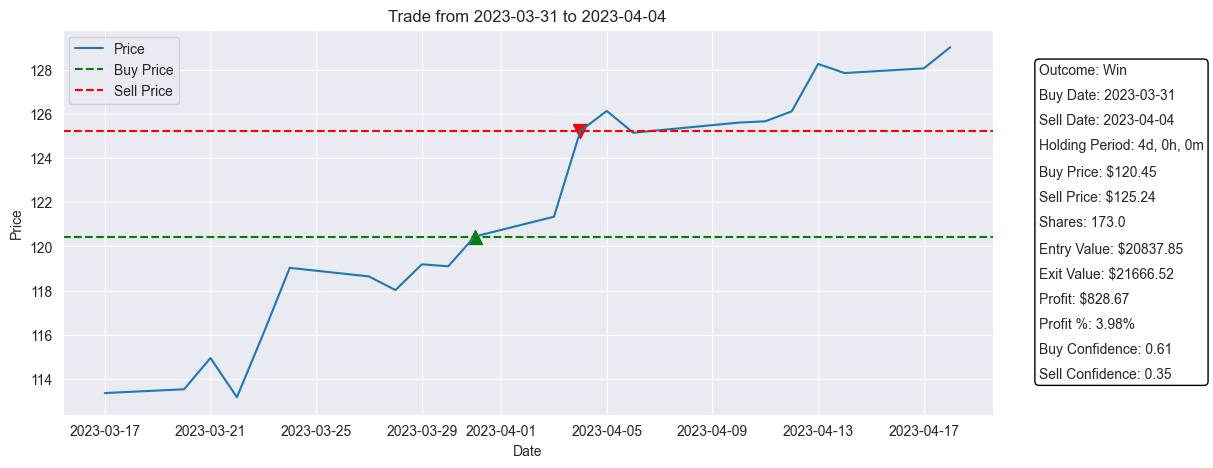

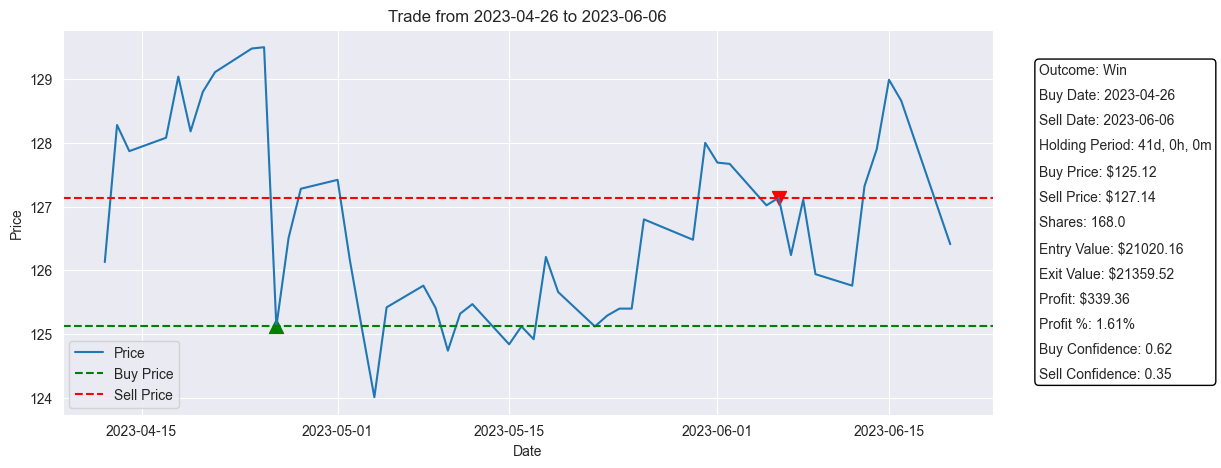

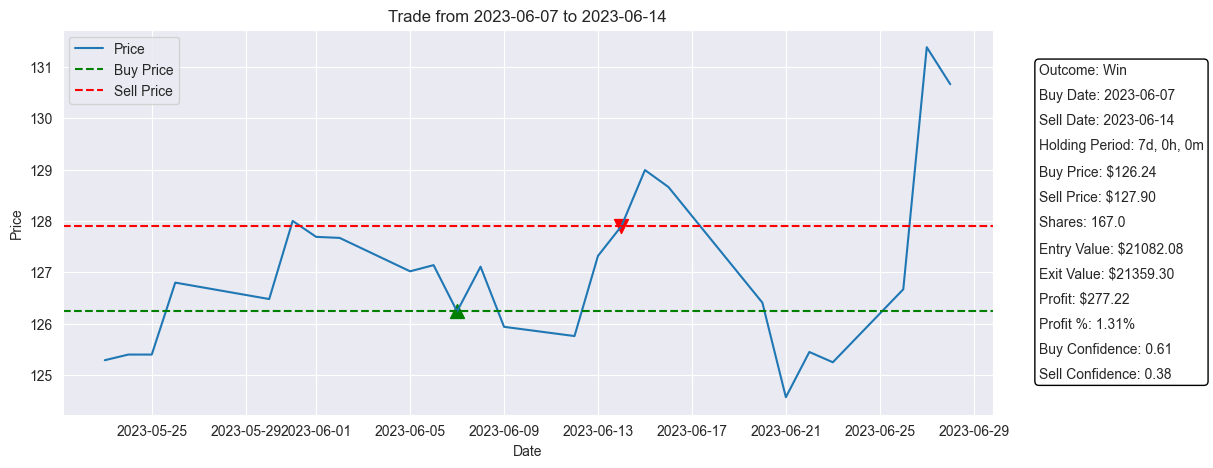

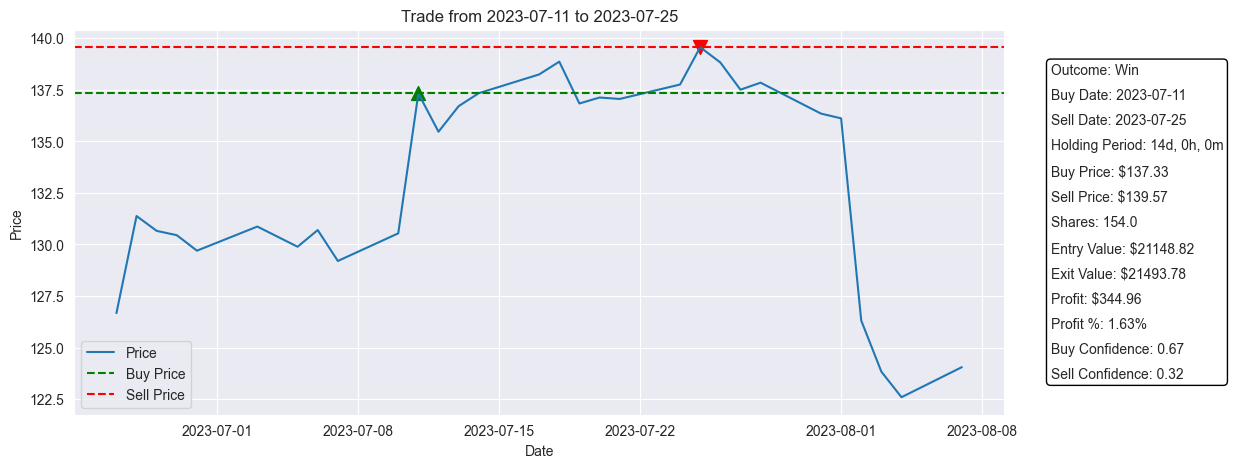

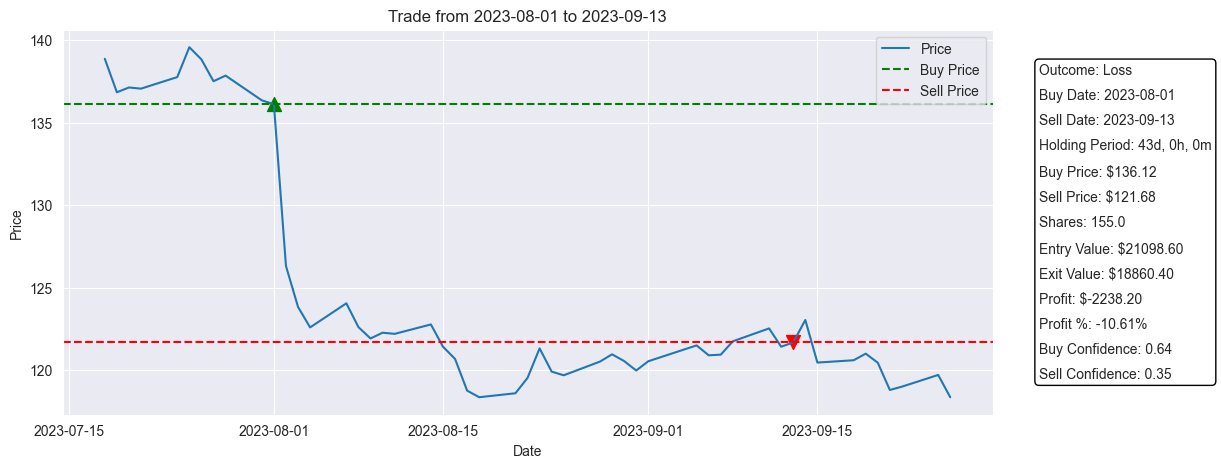

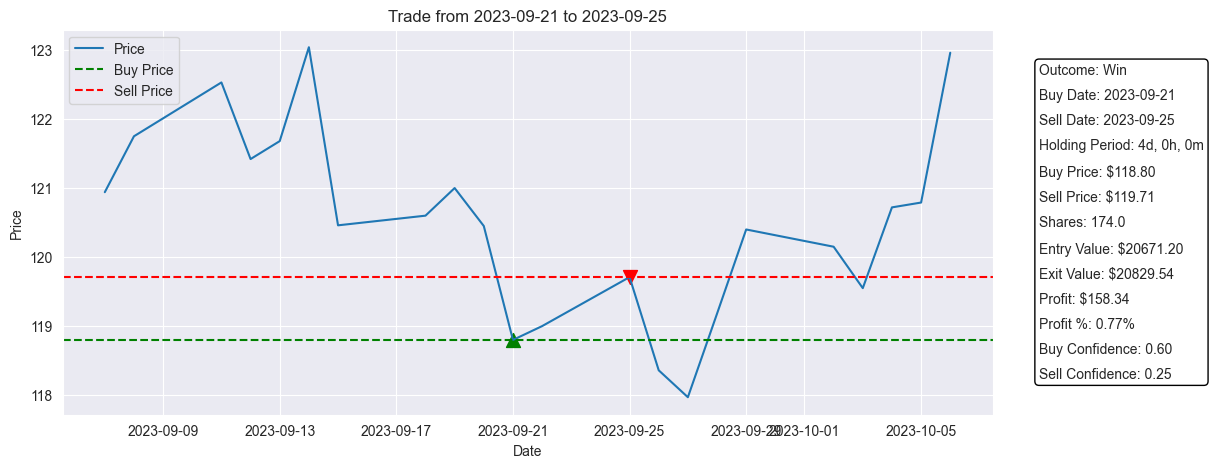

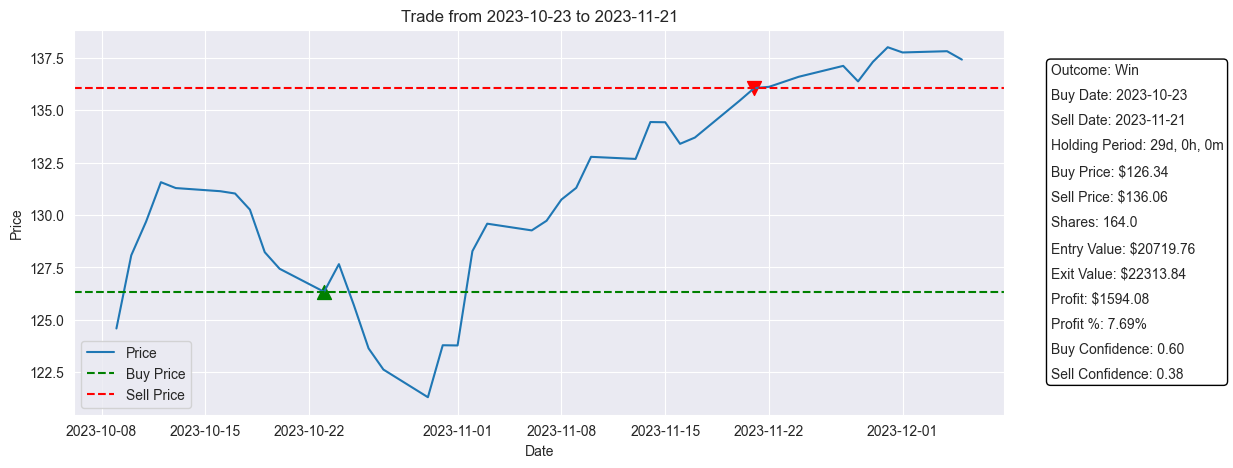

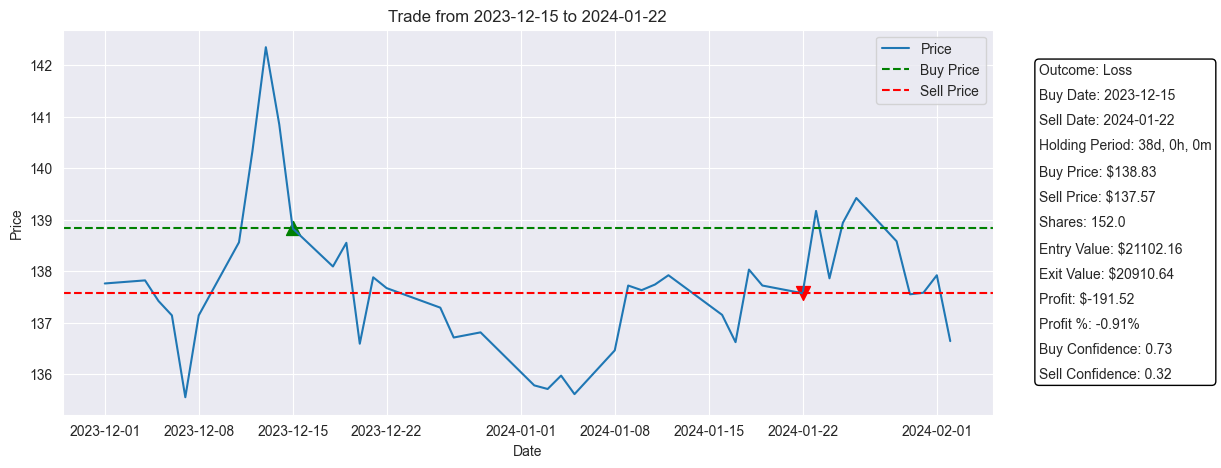

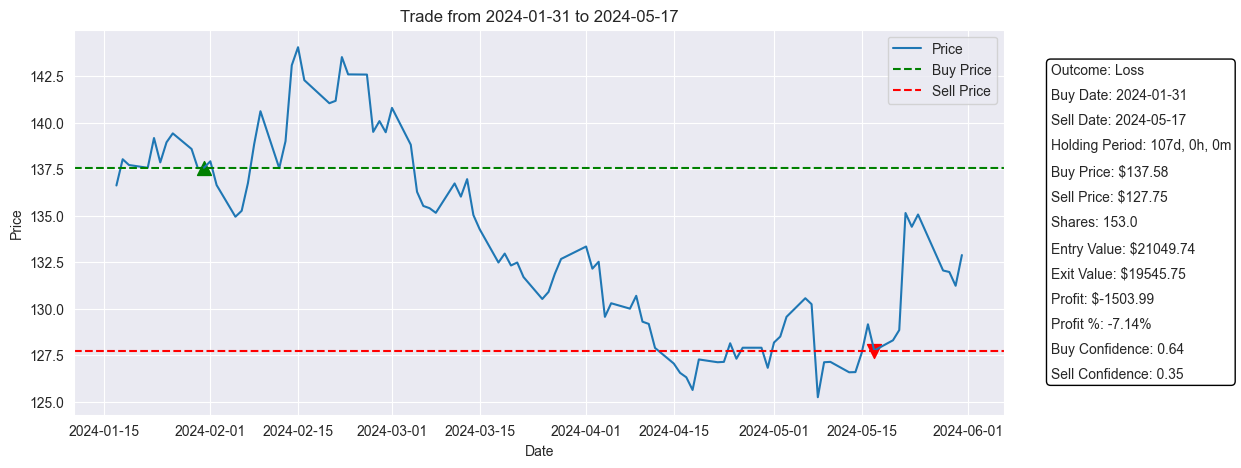

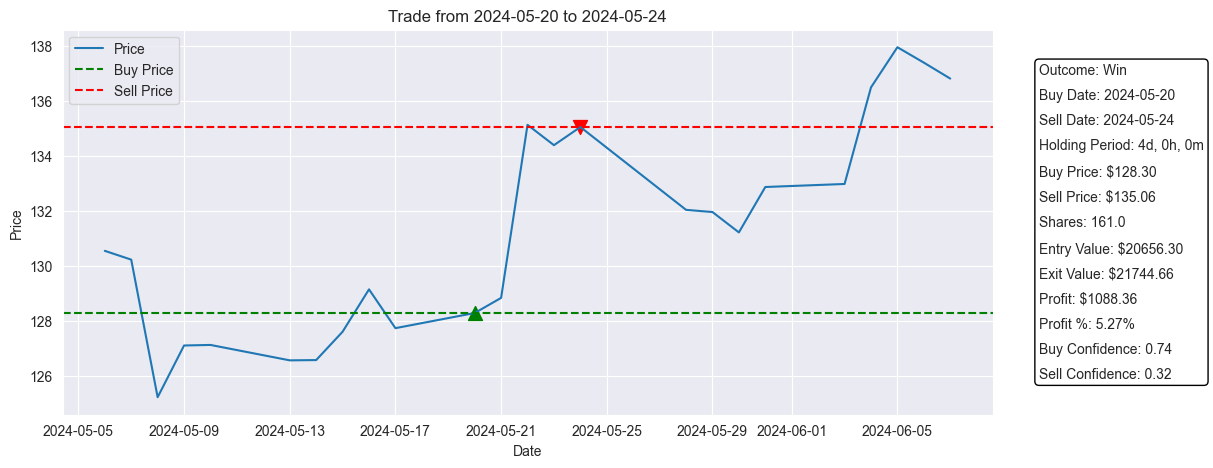

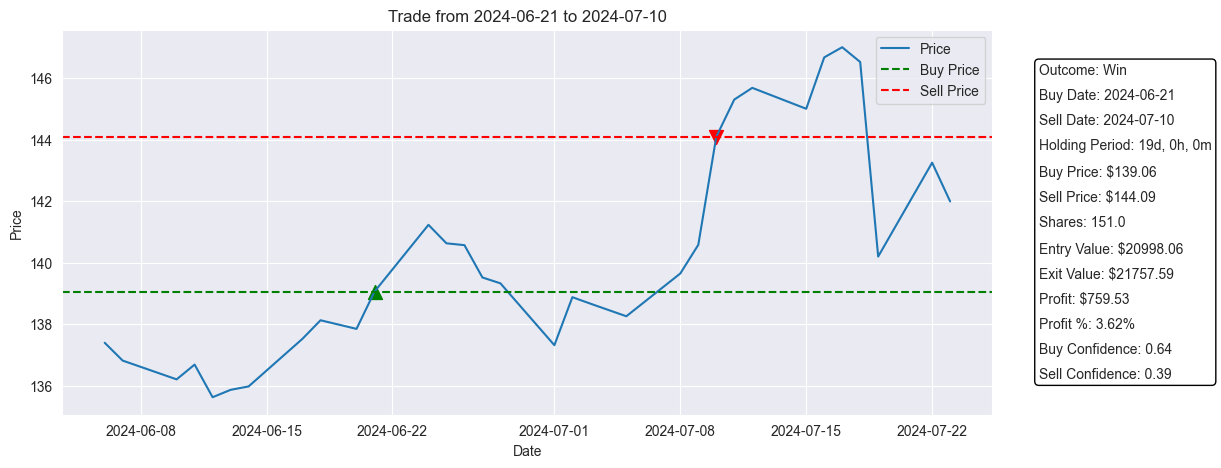

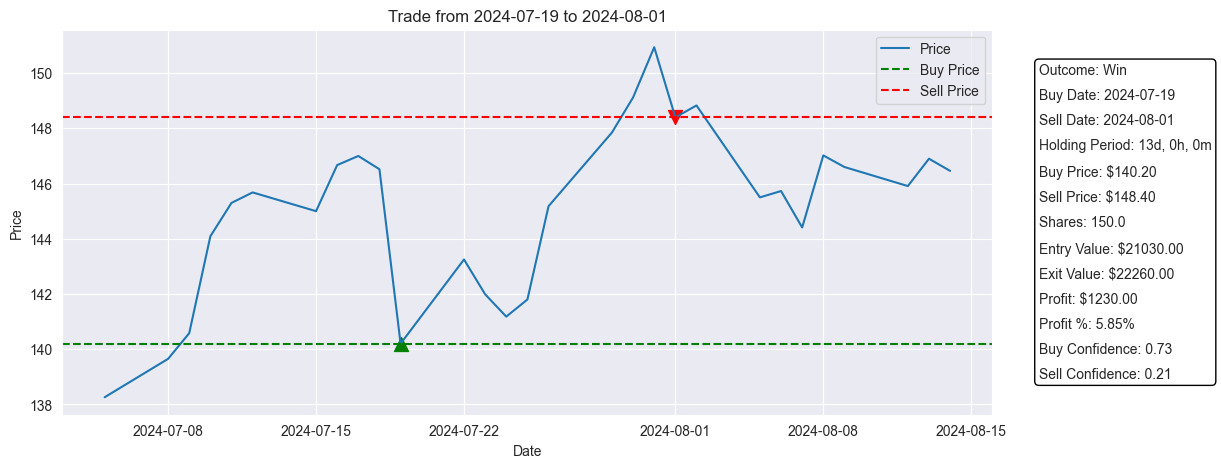

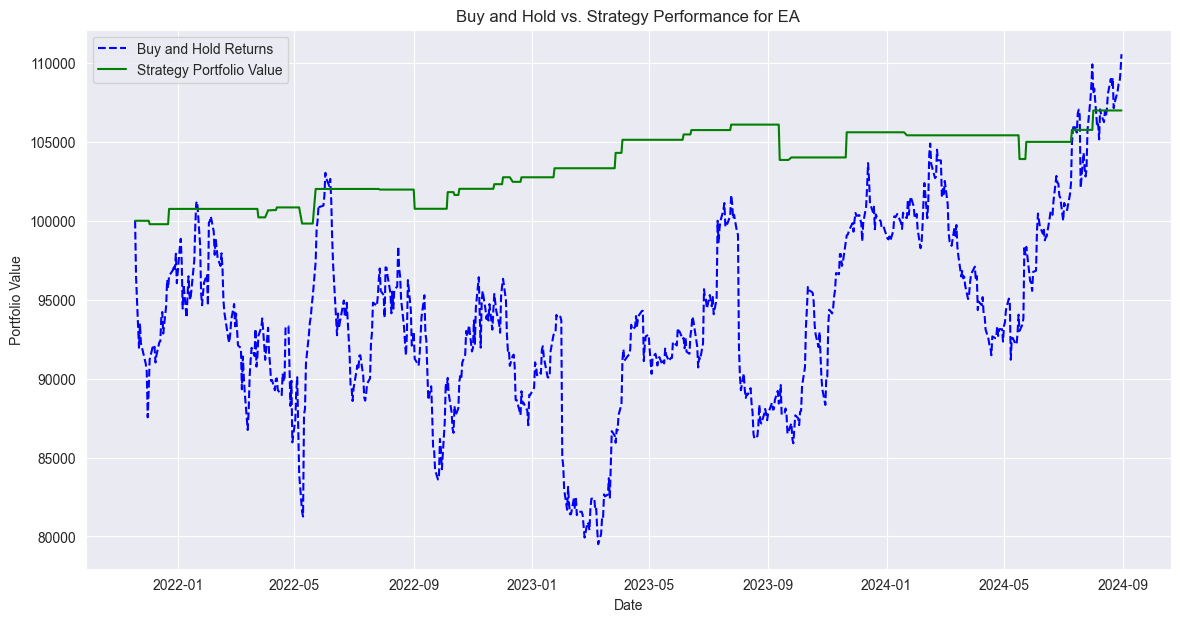

In [17]:
# Cell 5 - Backtesting Strategy

# Initial Variables Setup
initial_capital = 100000
position = 0
portfolio_value = initial_capital
capital_allocation = 0.2
positions = []
signals = []
confidence_levels = []
trade_details = []
max_drawdown = 0
max_portfolio_value = portfolio_value
portfolio_values = [portfolio_value]  # Track portfolio value over time

# Ensure the data only includes valid trading periods
if timeframe.endswith('d') or timeframe.endswith('wk') or timeframe.endswith('mo'):
    df = df[df.index.dayofweek < 5]  # Only weekdays for daily and above timeframes

# Calculate Buy and Hold strategy performance
buy_and_hold_returns = df['Close'].iloc[len(X_train):] / df['Close'].iloc[len(X_train)] * initial_capital

# Backtesting Process
print('////////////////////CONFIDENCE LEVEL PER CANDLESTICK PREDICTION////////////////////')
for i in tqdm(range(len(X_test)), desc='Backtesting Progress'):
    signal = model.predict_proba(X_test.iloc[i:i+1])[0][1]
    signals.append(signal)
    confidence_levels.append(signal)
    
    print(f"Row {i + len(X_train)} - Confidence Level: {signal:.4f}")

    if signal > 0.6 and position == 0:
        buy_price = df.iloc[len(X_train) + i]['Close']
        shares = (portfolio_value * capital_allocation) // buy_price
        entry_value = shares * buy_price
        position = 1
        positions.append(('Buy', df.index[len(X_train) + i], buy_price, shares, signal))

    elif signal <= 0.4 and position == 1:
        sell_price = df.iloc[len(X_train) + i]['Close']
        exit_value = shares * sell_price
        profit_value = exit_value - (shares * buy_price)
        profit_percentage = (profit_value / (shares * buy_price)) * 100
        portfolio_value += profit_value
        position = 0
        positions.append(('Sell', df.index[len(X_train) + i], sell_price, shares, signal))

        # Calculate the holding period
        holding_period = positions[-1][1] - positions[-2][1]
        holding_days = holding_period.days
        holding_seconds = holding_period.seconds
        holding_hours = holding_seconds // 3600
        holding_minutes = (holding_seconds % 3600) // 60

        holding_period_str = f"{holding_days}d, {holding_hours}h, {holding_minutes}m"

        # Format dates based on timeframe
        date_format = '%Y-%m-%d %H:%M' if timeframe.endswith('h') or timeframe.endswith('min') else '%Y-%m-%d'
        
        trade_details.append({
            'Outcome': 'Win' if profit_value > 0 else 'Loss',
            'Buy Date': positions[-2][1].strftime(date_format),
            'Sell Date': positions[-1][1].strftime(date_format),
            'Holding Period': holding_period_str,
            'Buy Price': positions[-2][2],
            'Sell Price': positions[-1][2],
            'Shares': positions[-2][3],
            'Entry Value': positions[-2][2] * positions[-2][3],
            'Exit Value': positions[-1][2] * positions[-1][3],
            'Profit': profit_value,
            'Profit %': profit_percentage,
            'Buy Confidence': positions[-2][4],
            'Sell Confidence': positions[-1][4]
        })

        max_portfolio_value = max(max_portfolio_value, portfolio_value)
        drawdown = max_portfolio_value - portfolio_value
        max_drawdown = max(max_drawdown, drawdown)

    portfolio_values.append(portfolio_value)  # Track portfolio value over time

# Print backtesting results
print('\n\n////////////////////PORTFOLIO SUMMARY////////////////////\n')
final_value = portfolio_value
total_profit = final_value - initial_capital
total_profit_percentage = (total_profit / initial_capital) * 100

print(f"\nFinal Portfolio Value: ${final_value:.2f}")
print(f"Total Profit: ${total_profit:.2f} ({total_profit_percentage:.2f}%)")

# Calculate and print Buy and Hold results
buy_and_hold_final_value = buy_and_hold_returns.iloc[-1]
buy_and_hold_profit = buy_and_hold_final_value - initial_capital
buy_and_hold_profit_percentage = (buy_and_hold_profit / initial_capital) * 100

total_trades = len(trade_details)
win_rate = (len([t for t in trade_details if t['Profit'] > 0]) / total_trades) if total_trades > 0 else 0
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Maximum Drawdown: -${abs(max_drawdown):.2f}")

if total_trades > 0:
    trade_table = pd.DataFrame(trade_details)
    returns = trade_table['Profit %'] / 100
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
else:
    print("Sharpe Ratio: N/A (No trades made)")

print(f"\nBuy and Hold Final Value: ${buy_and_hold_final_value:.2f}")
print(f"Buy and Hold Profit: ${buy_and_hold_profit:.2f} ({buy_and_hold_profit_percentage:.2f}%)")

print('\n\n////////////////////LIST OF TRADES////////////////////\n')
if total_trades > 0:
    trade_table = pd.DataFrame(trade_details).round(3)
    print("\nTrade Details Table:")
    print(trade_table)
else:
    print("No trades made during the backtest period.")

# Plotting Overall Signals
plt.figure(figsize=(14, 7))
plt.plot(df.index[len(X_train):], df['Close'].iloc[len(X_train):], label='Price')
buy_signals = [p for p in positions if p[0] == 'Buy']
sell_signals = [p for p in positions if p[0] == 'Sell']
plt.scatter([p[1] for p in buy_signals], [p[2] for p in buy_signals], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter([p[1] for p in sell_signals], [p[2] for p in sell_signals], marker='v', color='r', label='Sell Signal', alpha=1)
plt.title(f'{ticker} Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting zoomed-in trade details
if total_trades > 0:
    for trade in trade_details:
        plt.figure(figsize=(12, 5))
        
        # Define a window around each trade for zoom-in
        buy_date = pd.to_datetime(trade['Buy Date'])
        sell_date = pd.to_datetime(trade['Sell Date'])
        window_start = df.index.get_loc(buy_date) - 10 if df.index.get_loc(buy_date) - 10 >= 0 else 0
        window_end = df.index.get_loc(sell_date) + 10 if df.index.get_loc(sell_date) + 10 <= len(df.index) else len(df.index)

        # Plotting the price data within the zoom window
        plt.plot(df.index[window_start:window_end], df['Close'].iloc[window_start:window_end], label='Price')

        # Adding horizontal lines for Buy and Sell prices
        plt.axhline(y=trade['Buy Price'], color='g', linestyle='--', label='Buy Price', linewidth=1.5)
        plt.axhline(y=trade['Sell Price'], color='r', linestyle='--', label='Sell Price', linewidth=1.5)

        # Scatter points for Buy and Sell signals
        plt.scatter(buy_date, trade['Buy Price'], color='g', marker='^', s=100)
        plt.scatter(sell_date, trade['Sell Price'], color='r', marker='v', s=100)

        # Plot title and labels with formatted dates
        plt.title(f"Trade from {trade['Buy Date']} to {trade['Sell Date']}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()

        # Add trade details beside the plot
        trade_info = (
            f"Outcome: {trade['Outcome']}\n"
            f"Buy Date: {trade['Buy Date']}\n"
            f"Sell Date: {trade['Sell Date']}\n"
            f"Holding Period: {trade['Holding Period']}\n"
            f"Buy Price: ${trade['Buy Price']:.2f}\n"
            f"Sell Price: ${trade['Sell Price']:.2f}\n"
            f"Shares: {trade['Shares']}\n"
            f"Entry Value: ${trade['Entry Value']:.2f}\n"
            f"Exit Value: ${trade['Exit Value']:.2f}\n"
            f"Profit: ${trade['Profit']:.2f}\n"
            f"Profit %: {trade['Profit %']:.2f}%\n"
            f"Buy Confidence: {trade['Buy Confidence']:.2f}\n"
            f"Sell Confidence: {trade['Sell Confidence']:.2f}"
        )

        # Position the trade details to the right side of the plot
        # Position the trade details to the right side of the plot
        plt.text(1.05, 0.5, trade_info, transform=plt.gca().transAxes, fontsize=10, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'), linespacing=2)

        plt.show()

# Plot comparing Buy and Hold with Strategy Performance
plt.figure(figsize=(14, 7))
plt.plot(df.index[len(X_train):], buy_and_hold_returns, label='Buy and Hold Returns', color='blue', linestyle='--')
plt.plot(df.index[len(X_train):], portfolio_values[1:], label='Strategy Portfolio Value', color='green')
plt.title(f'Buy and Hold vs. Strategy Performance for {ticker}')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()


## Results Analysis

Based on the provided backtesting results, we can draw the following insights:

1. **Overall Performance**:
   - The strategy achieved a final portfolio value of $106,988.27, representing a total profit of $6,988.27 (6.99% return) on an initial investment of $100,000.
   - This underperformed the buy-and-hold strategy, which would have yielded a profit of $10,551.23 (10.55% return).

2. **Trade Statistics**:
   - The strategy executed 31 trades in total.
   - The win rate was 67.74%, meaning more than two-thirds of the trades were profitable.

3. **Risk Metrics**:
   - The maximum drawdown was $2,238.20, indicating the largest peak-to-trough decline in portfolio value.
   - The Sharpe ratio of 4.03 suggests a good risk-adjusted return, as it's well above the generally accepted threshold of 1 for a good investment.


4. **Individual Trade Performance**:
   - The most profitable trade yielded a 7.69% return over 29 days (October 23, 2023, to November 21, 2023).
   - The largest loss was a 10.61% decline over 43 days (August 1, 2023, to September 13, 2023).

5. **Strategy Behavior**:
   - The strategy demonstrated a high win rate, with consistent, albeit modest, gains.
   - However, it also showed vulnerability to significant losses, with one trade resulting in a 10.61% loss over 43 days.

6. **Comparison to Buy-and-Hold**:
   - The strategy underperformed the simple buy-and-hold approach by 3.56 percentage points (6.99% vs 10.55%).
   - This suggests that the machine learning model, while effective in generating profitable trades, did not capture enough value to outperform the passive strategy.

## Insights and Implications

1. **Potential for Outperformance**: The strategy's ability to generate a high win rate indicates that it can provide consistent returns, although these returns were lower than the buy-and-hold strategy.

2. **Risk Management Importance**: The presence of significant losing trades highlights the importance of robust risk management techniques, such as stop-loss orders or dynamic position sizing, which could be incorporated in future iterations.

3. **Market Timing Capability**: The strategy's win rate of 67.74% and overall profitability indicate some success in market timing, but there's a need to optimize the model further to improve returns.

4. **Long-Term Perspective**: The holding periods varied, with the most profitable trade lasting 29 days, suggesting that the strategy might be better suited for short to medium-term trades.

5. **Adaptability to Market Conditions**: The varying holding periods (from 1 day to 73 days) demonstrate the strategy's flexibility in adapting to different market conditions.

6. **Emotion-Free Trading**: The systematic nature of the strategy allows for emotion-free trading decisions, which can be advantageous in volatile markets. However, further refinement is needed to optimize performance relative to simpler strategies like buy-and-hold.

## Disclaimer

This backtesting strategy and its results are for informational purposes only and should not be considered financial advice. Historical performance does not guarantee future results. Real-world trading involves factors such as liquidity, transaction costs, and market impact that are not accounted for in the backtester. Trading strategies carry risks, and individual financial situations should be considered before implementing any strategy. Consult a qualified financial advisor before making investment decisions.

## Cell 6: Feature Importance Analysis

**Introduction to Feature Importance**

In machine learning, particularly in models like the Random Forest Classifier, understanding which features (or inputs) are most influential in making predictions is crucial. Feature importance helps us identify which technical indicators and stock attributes contribute the most to predicting whether EA's stock price will go up or down. This insight not only guides model training but also helps in refining the strategy to focus on the most impactful features.

This feature importance analysis covers a wide range of technical indicators and stock attributes, such as RSI (Relative Strength Index), MACD (Moving Average Convergence Divergence), SMA (Simple Moving Averages), and more. These features are calculated from the historical stock data and are used by the Random Forest model to make predictions.

**Technical Indicators Included:** RSI, Stochastic Oscillator (Stoch_K and Stoch_D), ADX (Average Directional Index), Volume, MACD, SMA, EMA (Exponential Moving Averages), Bollinger Bands, ATR (Average True Range), and price-related features (Open, High, Low, Close, Adj Close).

Identifying the most important features helps in prioritizing those that contribute the most to the model's decision-making process. This prioritization can lead to more efficient and accurate model training, by focusing on features that matter and potentially discarding those that do not add value.


Feature Importance:
                 feature  importance
14                   RSI        0.06
22               Stoch_D        0.06
21               Stoch_K        0.06
23                   ADX        0.06
13                Volume        0.06
15                  MACD        0.05
16           MACD_signal        0.05
17                   ATR        0.05
8                 SMA200        0.04
0                   Open        0.04
18              BB_upper        0.04
20              BB_lower        0.04
1                   High        0.04
6                  SMA50        0.04
2                    Low        0.04
3                  Close        0.04
4              Adj Close        0.04
7                 SMA100        0.03
10                 EMA50        0.03
12                EMA200        0.03
5                  SMA20        0.03
19             BB_middle        0.03
11                EMA100        0.03
9                  EMA20        0.03
34      ADX_Strong_Trend        0.00
24          Above

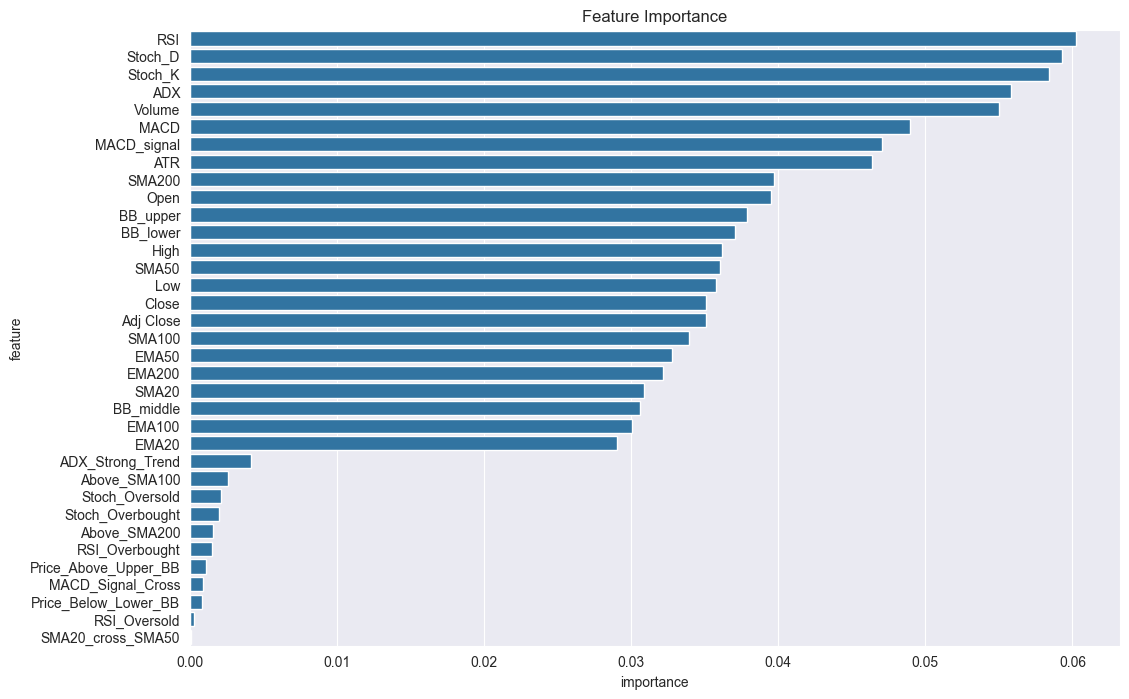

In [64]:
# Cell 6: Feature Importance Analysis
feature_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.round(3))

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

## Insights and Their Importance

**Top Features (RSI, Stoch_D, Stoch_K, ADX, Volume):**

- These features are the most influential in the model's predictions. RSI, Stochastic Oscillators, and ADX are commonly used in technical analysis to identify momentum and trend strength, making them valuable for predicting price movements.

- Emphasizing these features in model training can enhance predictive accuracy. Future iterations of the model could focus on fine-tuning how these features are calculated or even developing new features that build on them.

**Moderately Important Features (MACD, SMA200, EMA50 Bollinger Bands):**

- These indicators help the model understand long-term trends and volatility. MACD, for example, is effective in identifying changes in momentum, while Bollinger Bands provide insights into market volatility.

- These features should be retained in the model, but further exploration into their parameter settings (e.g., different time periods for moving averages) could yield improvements.

**Low to Zero Importance Features:**

- Features with low or zero importance are not contributing significantly to the model's decision-making process.
- These features might be candidates for removal in future model iterations, simplifying the model and potentially reducing overfitting. 

## Next Step

Understanding feature importance is crucial for improving our machine learning model. By focusing on the most impactful features, we can refine our model to be more efficient and effective in predicting stock price movements. This process not only enhances model performance but also ensures that the strategy is built on sound, data-driven foundations.

In subsequent model training, special attention will be given to the top features identified.









# Cell 7: Hyperparameter Tuning

This cell performs hyperparameter tuning for a Random Forest Classifier using manual iteration over a defined grid of hyperparameters. The best parameter combination is selected based on the highest score achieved on the test set.

## Variable Assumption and Data Splitting

The variables X and y are assumed to be defined as features and target, respectively. The data is split into training (X_train, y_train) and testing (X_test, y_test) sets, with 80% allocated for training and 20% for testing. The split is not randomized and retains the time series structure.

## Defining Parameters

The parameter grid is defined to specify the hyperparameters to be tuned:

n_estimators: Number of trees in the forest [100, 200, 500]
max_depth: Maximum depth of each tree [10, 20, 30, None]
min_samples_split: Minimum number of samples required to split an internal node [2, 5, 10]
min_samples_leaf: Minimum number of samples required to be at a leaf node [1, 2, 4]
bootstrap: Whether bootstrap samples are used when building trees [True, False]

## Tuning Process

The tuning process iterates over all possible combinations of the defined hyperparameters. For each combination, the RandomForestClassifier is initialized with the current parameters and trained on X_train, y_train. The model's performance is then evaluated on the test set (X_test, y_test). The best performing parameter combination is stored.

A progress bar is displayed to track the tuning process, with a small delay introduced after each iteration to enhance visibility.

## Model Evaluation

The best model, determined by the highest test set score, is refit on the training data. Predictions (y_pred) are made on the test set, and a classification report is generated, including metrics like precision, recall, and F1-score.

## Confusion Matrix

A confusion matrix is constructed from the prediction results to visualize the model's performance. The matrix is rearranged and plotted to highlight the accuracy of positive and negative classifications.



Starting hyperparameter tuning...


Hyperparameter Tuning Progress:   0%|          | 0/216 [00:00<?, ?it/s]


Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Current score: 0.5250

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False}
Current score: 0.5279

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': True}
Current score: 0.5150

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False}
Current score: 0.5179

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True}
Current score: 0.5207

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}
Current score: 0.5336

Current parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'b

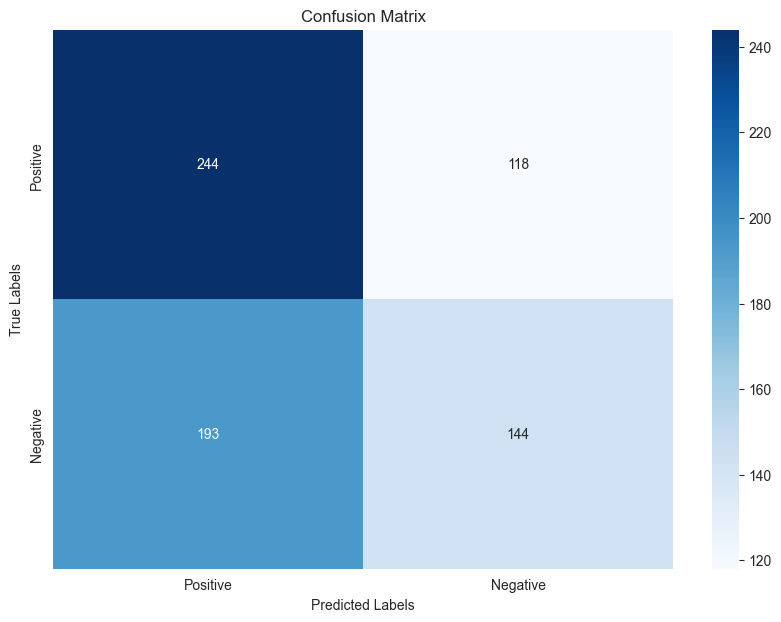

In [6]:
# Cell 7 - Hyperparameter tuning

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Calculate total iterations
param_combinations = list(product(*param_grid.values()))
n_iterations = len(param_combinations)

print("Starting hyperparameter tuning...")

best_score = 0
best_params = None

with tqdm(total=n_iterations, desc="Hyperparameter Tuning Progress") as pbar:
    for params in param_combinations:
        current_params = dict(zip(param_grid.keys(), params))
        model.set_params(**current_params)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_params = current_params
        
        pbar.update(1)
        print(f"\nCurrent parameters: {current_params}")
        print(f"Current score: {score:.4f}")
        
        time.sleep(0.1)  # Small delay to make the progress visible

print("\nHyperparameter tuning completed.")

print("\nBest Parameters: ", best_params)
print("\nBest Score:", best_score)

# Evaluate the best model
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_rearranged = cm[[1, 0], :][:, [1, 0]]

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rearranged, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Positive', 'Negative'], 
            yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
